In [2]:
!pip install catboost

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

In [60]:
df = pd.read_csv(r"https://raw.githubusercontent.com/dsrscientist/dataset3/main/weatherAUS.csv")
pd.set_option("display.max_columns", None)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
8421,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
8422,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
8423,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [61]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 16
Discrete feature Count 2
Continuous feature Count 14
Categorical feature Count 7


In [62]:
df.isnull().sum()*100/len(df)

Date              0.000000
Location          0.000000
MinTemp           0.890208
MaxTemp           0.712166
Rainfall          2.848665
Evaporation      41.685460
Sunshine         47.406528
WindGustDir      11.762611
WindGustSpeed    11.762611
WindDir9am        9.839763
WindDir3pm        3.655786
WindSpeed9am      0.902077
WindSpeed3pm      1.270030
Humidity9am       0.700297
Humidity3pm       1.210682
Pressure9am      15.537092
Pressure3pm      15.572700
Cloud9am         28.735905
Cloud3pm         29.139466
Temp9am           0.664688
Temp3pm           1.139466
RainToday         2.848665
RainTomorrow      2.836795
dtype: float64

In [63]:
print(numerical_feature)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [64]:
def randomsampleimputation(df, variable):
    df[variable]=df[variable]
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable]=random_sample

In [65]:
randomsampleimputation(df, "Cloud9am")
randomsampleimputation(df, "Cloud3pm")
randomsampleimputation(df, "Evaporation")
randomsampleimputation(df, "Sunshine")

In [66]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,3.0,13.8,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,8.0,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,2.2,7.6,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,1.0,4.0,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,4.6,7.7,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,2.0,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,1.8,8.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,8.0,7.0,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,3.8,11.9,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2017-06-21,Uluru,2.8,23.4,0.0,6.4,1.2,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,8.0,4.0,10.1,22.4,No,No
8421,2017-06-22,Uluru,3.6,25.3,0.0,12.6,7.1,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,1.0,1.0,10.9,24.5,No,No
8422,2017-06-23,Uluru,5.4,26.9,0.0,4.2,13.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,6.0,5.0,12.5,26.1,No,No
8423,2017-06-24,Uluru,7.8,27.0,0.0,4.0,13.1,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


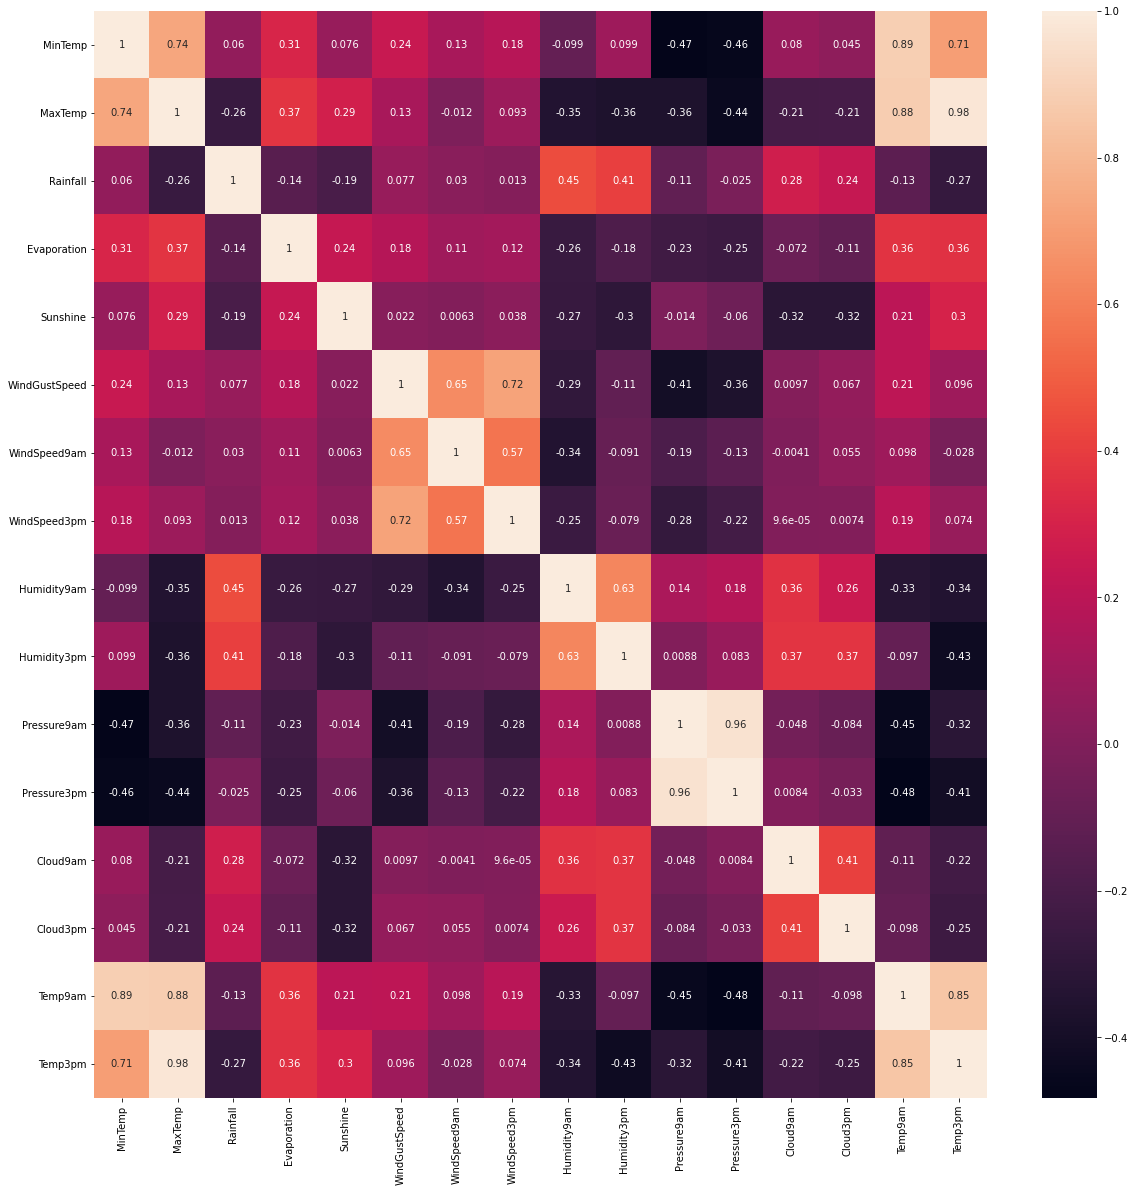

In [67]:
corrmat = df.corr(method = "spearman")
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

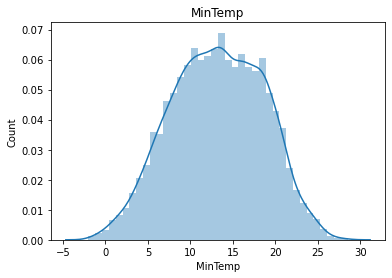

<Figure size 1080x1080 with 0 Axes>

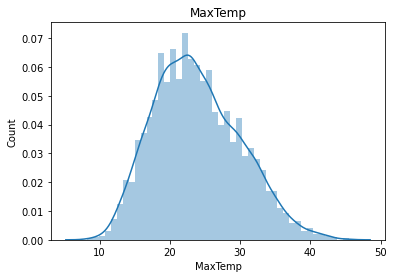

<Figure size 1080x1080 with 0 Axes>

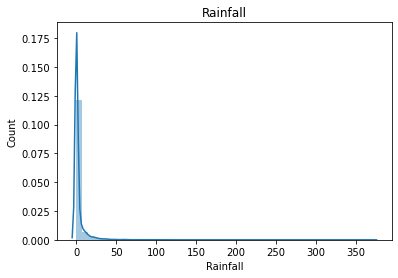

<Figure size 1080x1080 with 0 Axes>

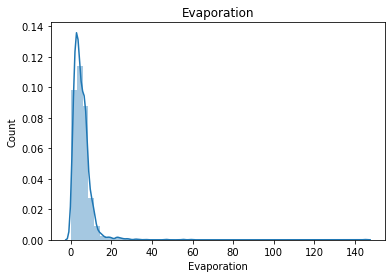

<Figure size 1080x1080 with 0 Axes>

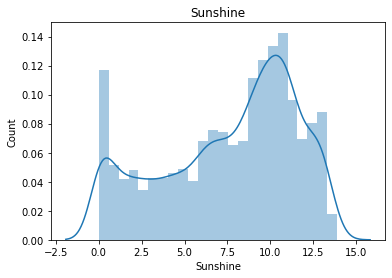

<Figure size 1080x1080 with 0 Axes>

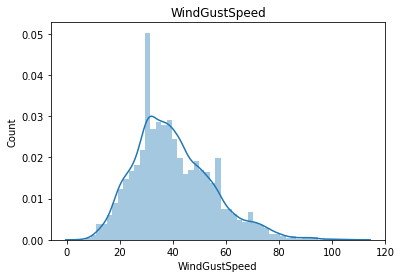

<Figure size 1080x1080 with 0 Axes>

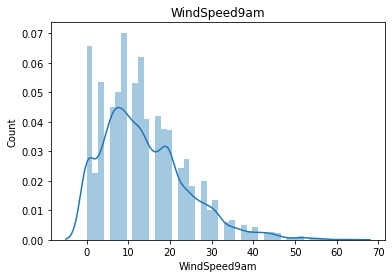

<Figure size 1080x1080 with 0 Axes>

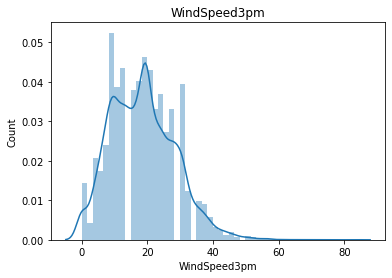

<Figure size 1080x1080 with 0 Axes>

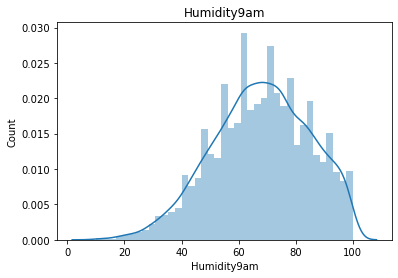

<Figure size 1080x1080 with 0 Axes>

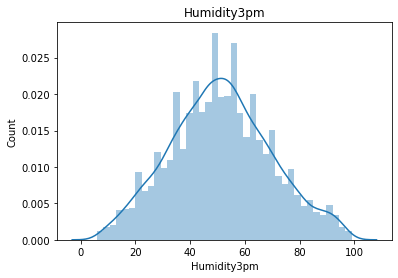

<Figure size 1080x1080 with 0 Axes>

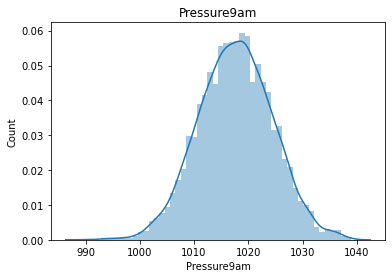

<Figure size 1080x1080 with 0 Axes>

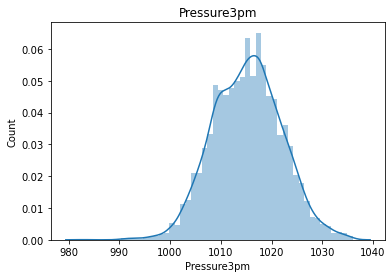

<Figure size 1080x1080 with 0 Axes>

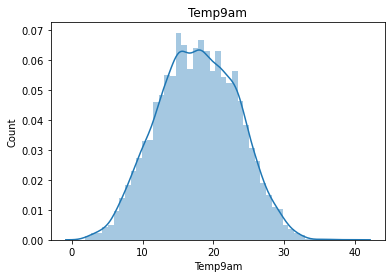

<Figure size 1080x1080 with 0 Axes>

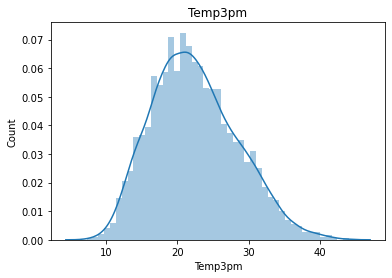

<Figure size 1080x1080 with 0 Axes>

In [68]:
for feature in continuous_feature:
    data=df.copy()
    sns.distplot(df[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

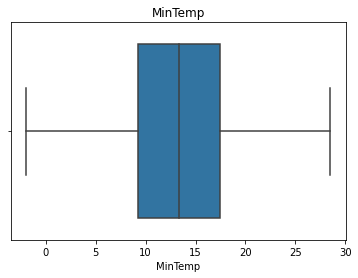

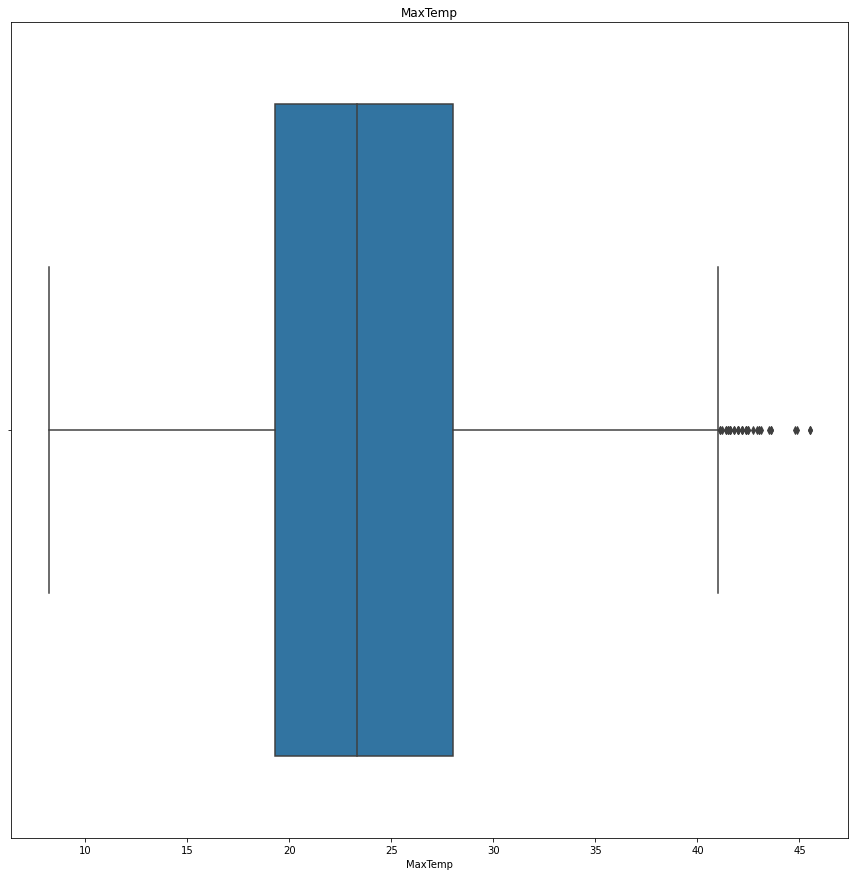

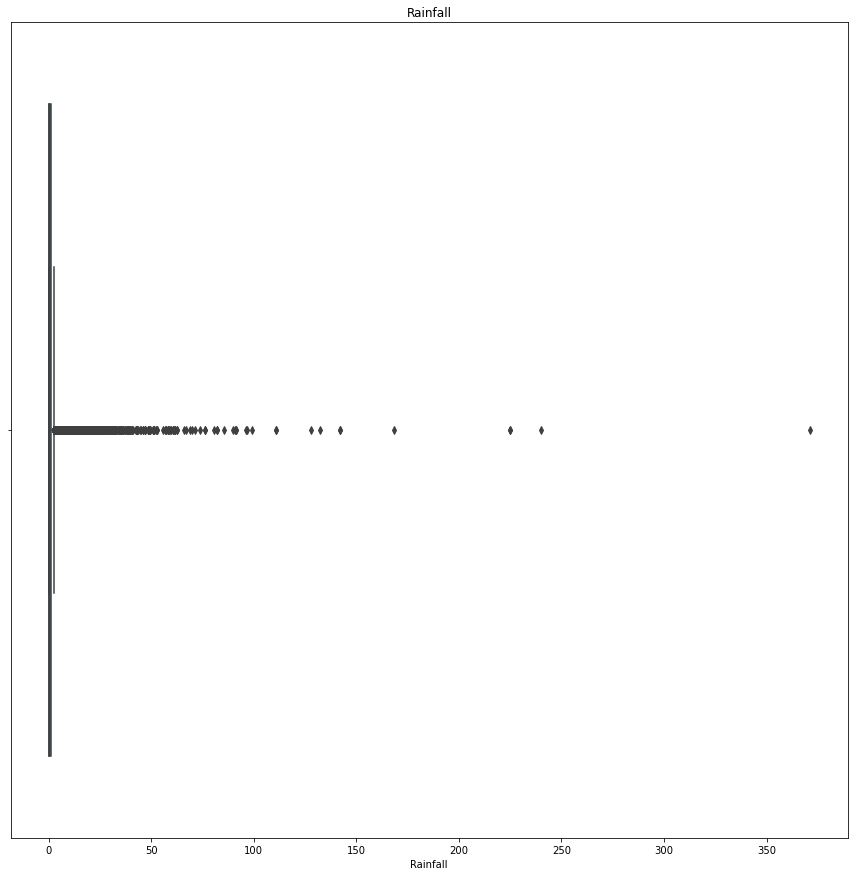

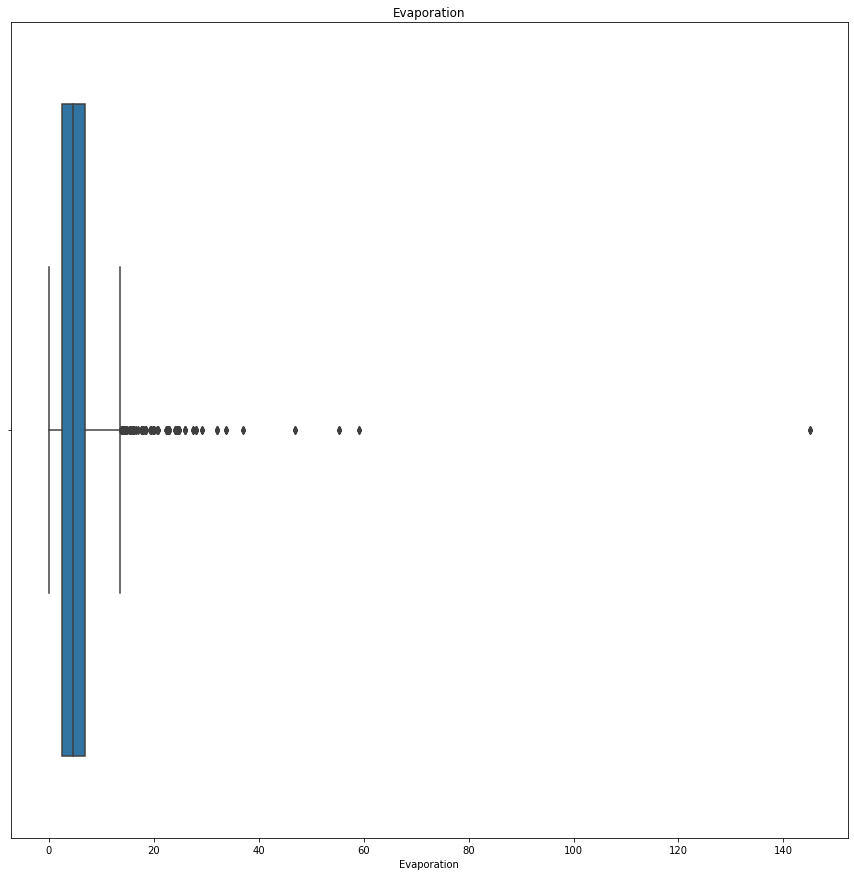

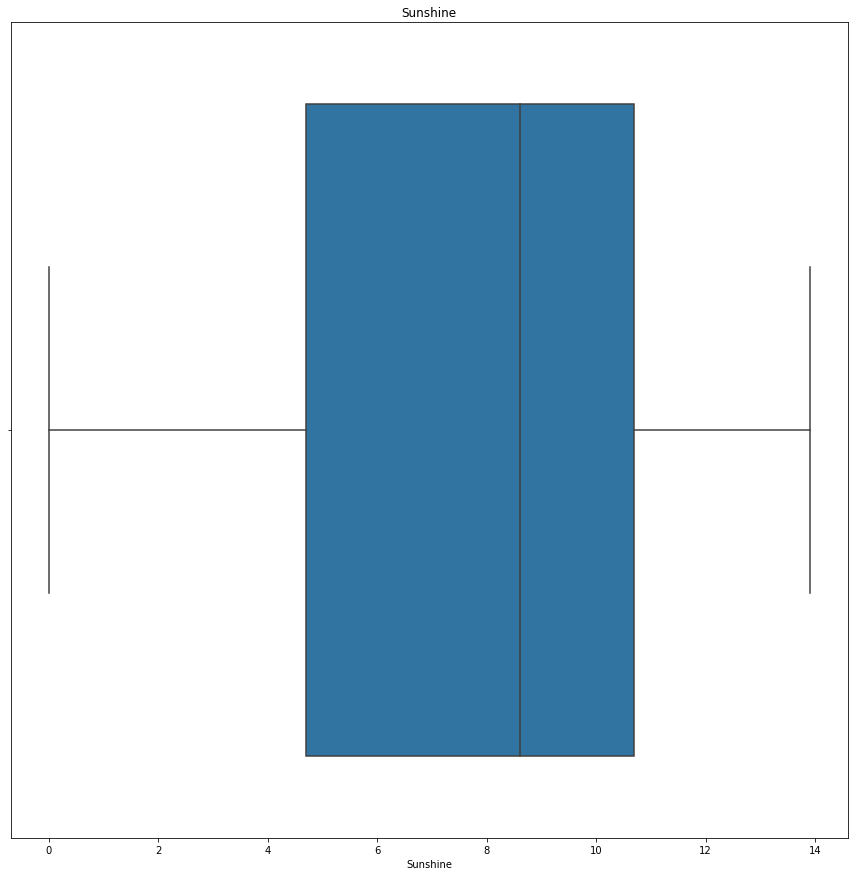

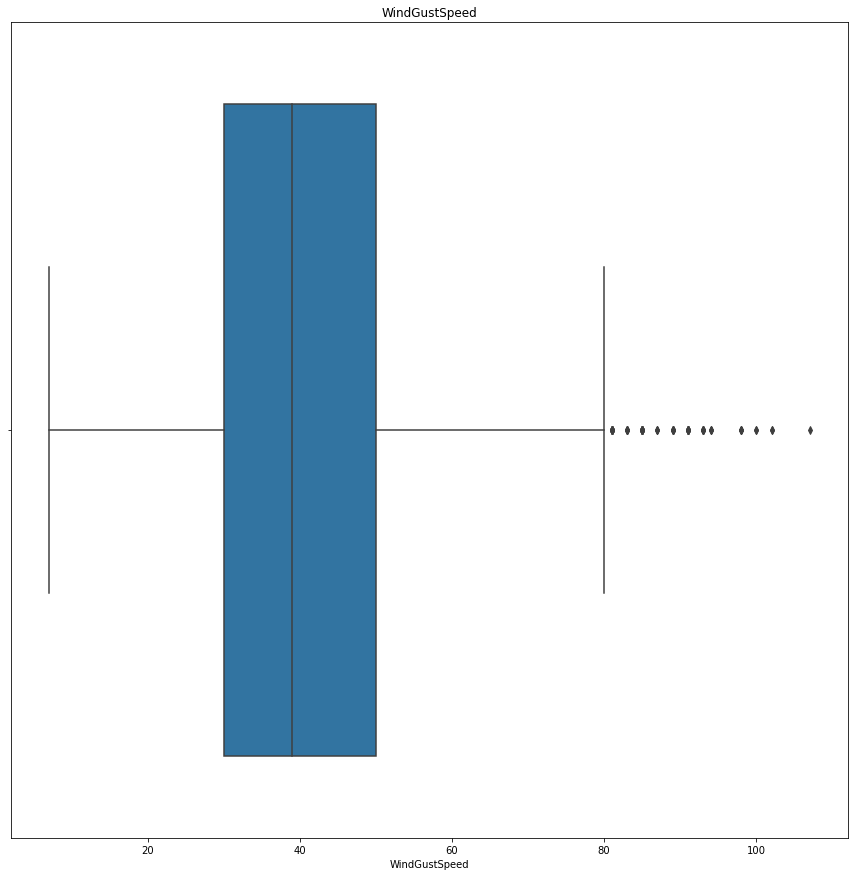

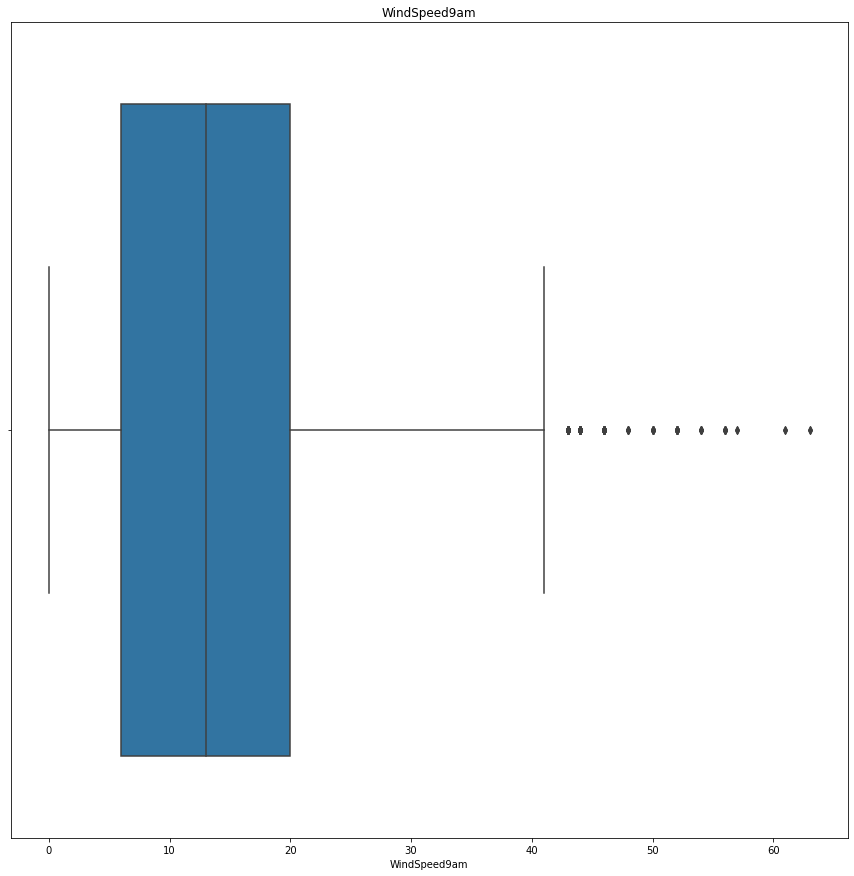

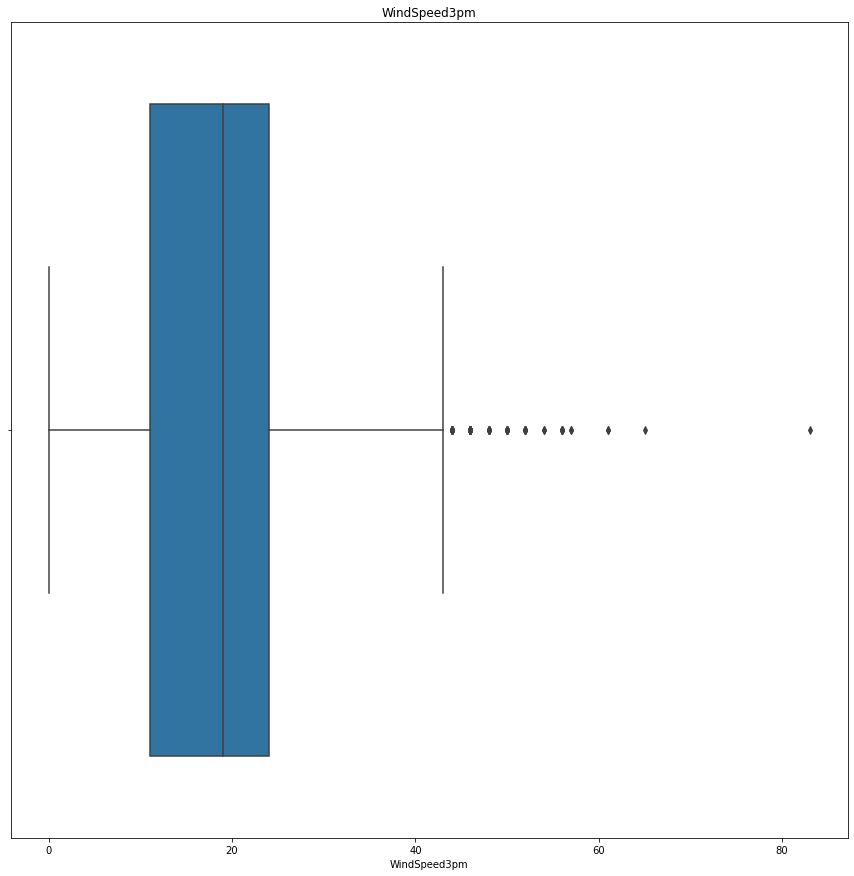

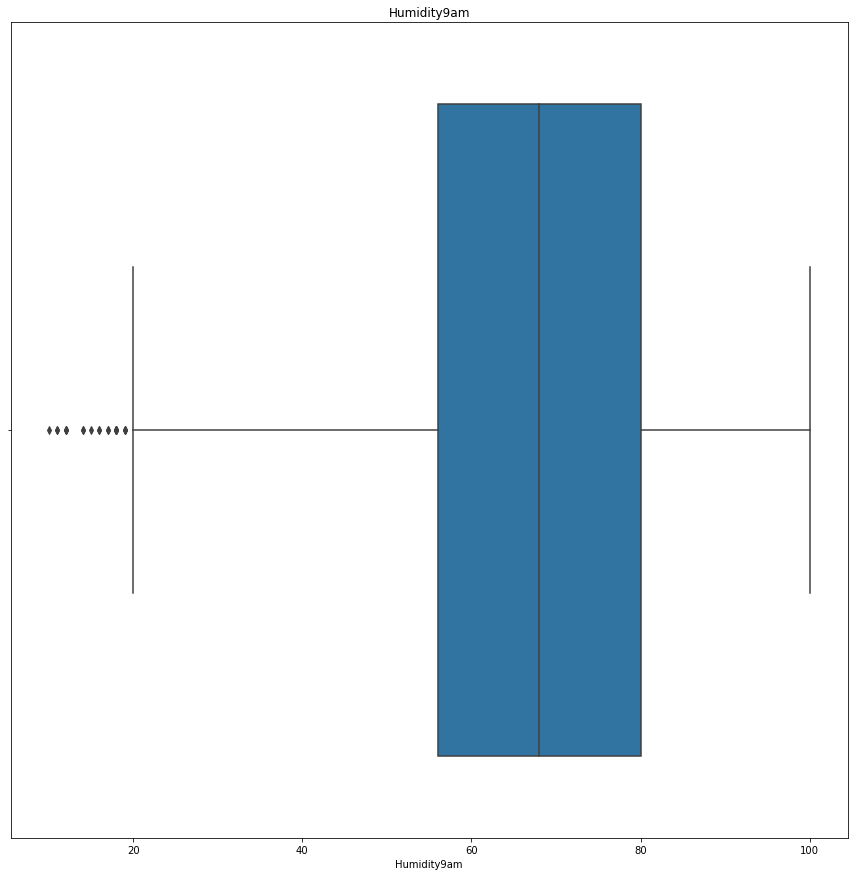

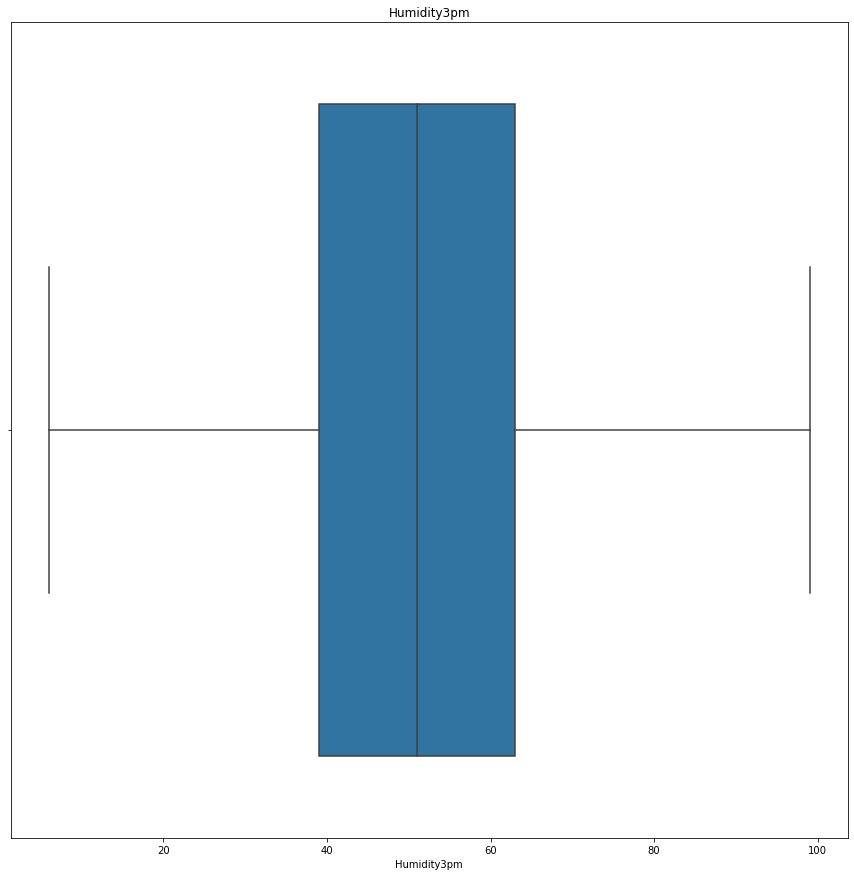

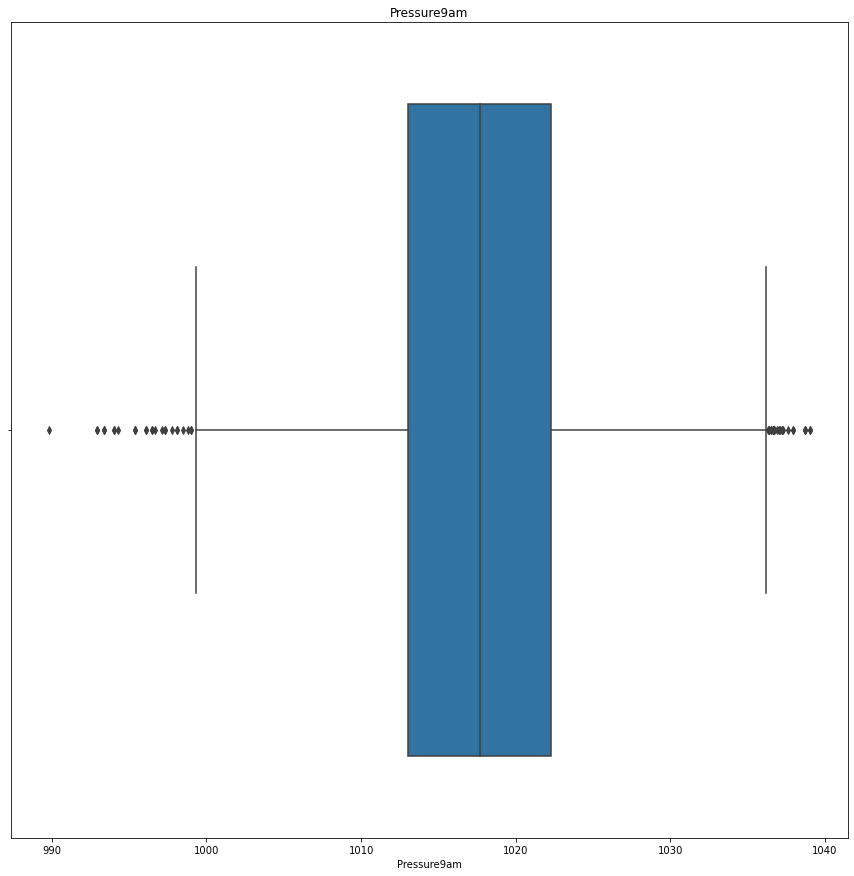

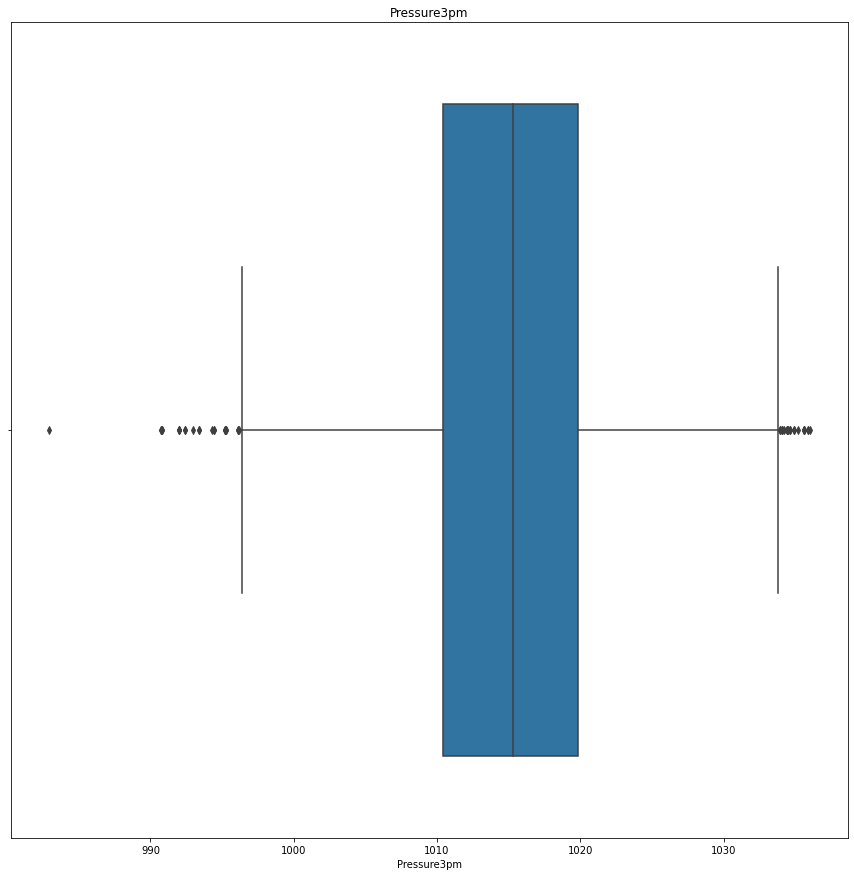

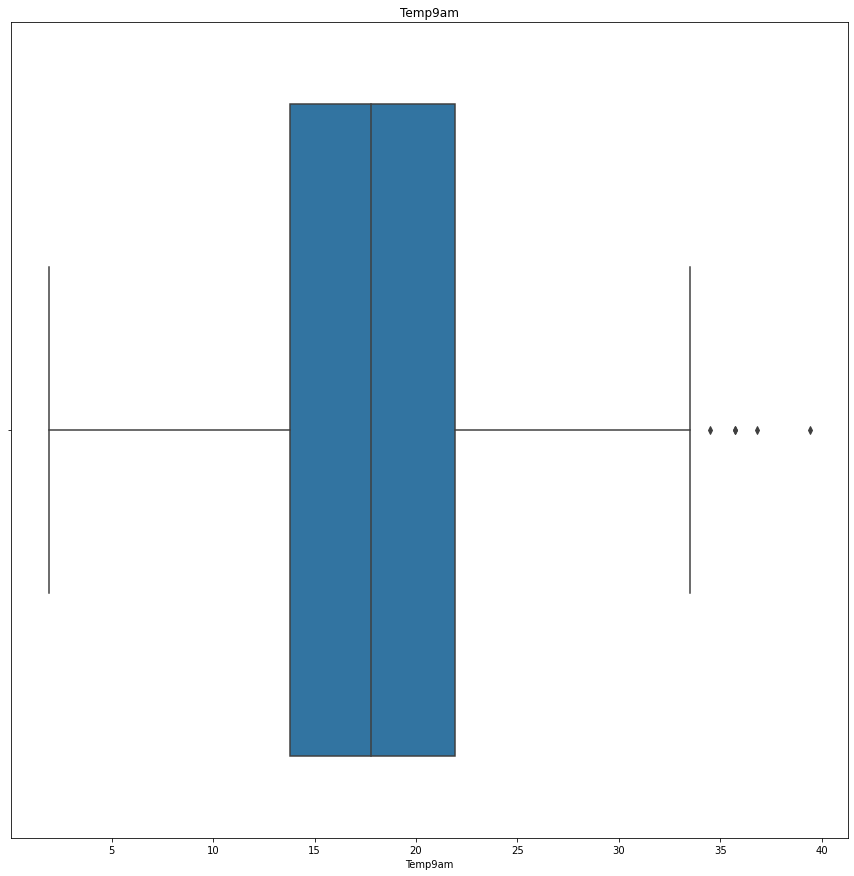

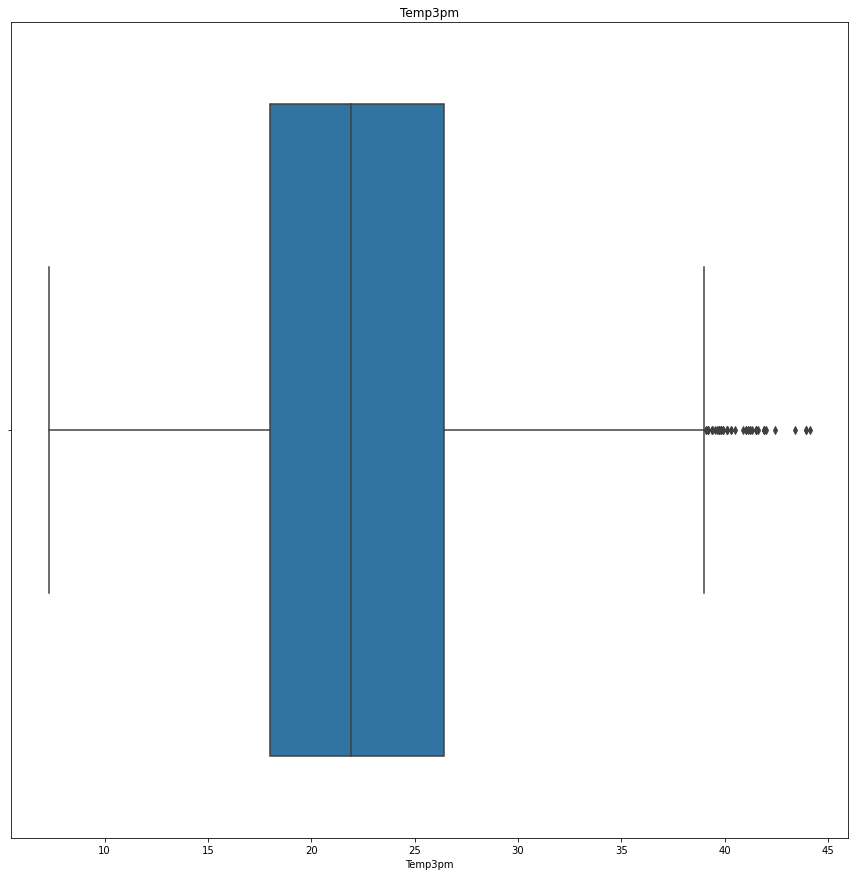

<Figure size 1080x1080 with 0 Axes>

In [69]:
#A for loop is used to plot a boxplot for all the continuous features to see the outliers
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [70]:
for feature in continuous_feature:
    if(df[feature].isnull().sum()*100/len(df))>0:
        df[feature] = df[feature].fillna(df[feature].median())

In [71]:
df.isnull().sum()*100/len(df)

Date              0.000000
Location          0.000000
MinTemp           0.000000
MaxTemp           0.000000
Rainfall          0.000000
Evaporation       0.000000
Sunshine          0.000000
WindGustDir      11.762611
WindGustSpeed     0.000000
WindDir9am        9.839763
WindDir3pm        3.655786
WindSpeed9am      0.000000
WindSpeed3pm      0.000000
Humidity9am       0.000000
Humidity3pm       0.000000
Pressure9am       0.000000
Pressure3pm       0.000000
Cloud9am          0.000000
Cloud3pm          0.000000
Temp9am           0.000000
Temp3pm           0.000000
RainToday         2.848665
RainTomorrow      2.836795
dtype: float64

In [72]:
discrete_feature

['Cloud9am', 'Cloud3pm']

In [73]:
def mode_nan(df,variable):
    mode=df[variable].value_counts().index[0]
    df[variable].fillna(mode,inplace=True)
mode_nan(df,"Cloud9am")
mode_nan(df,"Cloud3pm")

In [74]:
df["RainToday"] = pd.get_dummies(df["RainToday"], drop_first = True)
df["RainTomorrow"] = pd.get_dummies(df["RainTomorrow"], drop_first = True)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,3.0,13.8,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,8.0,16.9,21.8,0,0
1,2008-12-02,Albury,7.4,25.1,0.0,2.2,7.6,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,1.0,4.0,17.2,24.3,0,0
2,2008-12-03,Albury,12.9,25.7,0.0,4.6,7.7,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,2.0,2.0,21.0,23.2,0,0
3,2008-12-04,Albury,9.2,28.0,0.0,1.8,8.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,8.0,7.0,18.1,26.5,0,0
4,2008-12-05,Albury,17.5,32.3,1.0,3.8,11.9,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2017-06-21,Uluru,2.8,23.4,0.0,6.4,1.2,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,8.0,4.0,10.1,22.4,0,0
8421,2017-06-22,Uluru,3.6,25.3,0.0,12.6,7.1,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,1.0,1.0,10.9,24.5,0,0
8422,2017-06-23,Uluru,5.4,26.9,0.0,4.2,13.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,6.0,5.0,12.5,26.1,0,0
8423,2017-06-24,Uluru,7.8,27.0,0.0,4.0,13.1,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0


In [75]:
for feature in categorical_feature:
    print(feature, (df.groupby([feature])["RainTomorrow"].mean().sort_values(ascending = False)).index)

Date Index(['2015-01-26', '2017-02-28', '2014-04-26', '2014-04-27', '2017-02-25',
       '2017-02-26', '2015-11-04', '2015-11-03', '2017-02-27', '2017-03-01',
       ...
       '2013-01-11', '2013-01-10', '2013-01-09', '2013-01-08', '2013-01-07',
       '2013-01-05', '2013-01-04', '2013-01-03', '2013-01-02', '2017-06-25'],
      dtype='object', name='Date', length=3004)
Location Index(['CoffsHarbour', 'Wollongong', 'Melbourne', 'Williamtown', 'Newcastle',
       'Penrith', 'Brisbane', 'Adelaide', 'Albury', 'PerthAirport', 'Darwin',
       'Uluru'],
      dtype='object', name='Location')
WindGustDir Index(['NNW', 'SSW', 'N', 'WSW', 'NW', 'SW', 'NNE', 'S', 'WNW', 'NE', 'SSE',
       'SE', 'ESE', 'W', 'ENE', 'E'],
      dtype='object', name='WindGustDir')
WindDir9am Index(['N', 'WNW', 'SW', 'W', 'NNE', 'NNW', 'SSW', 'ESE', 'WSW', 'S', 'NW',
       'NE', 'SSE', 'SE', 'ENE', 'E'],
      dtype='object', name='WindDir9am')
WindDir3pm Index(['NNW', 'SSW', 'N', 'NW', 'S', 'WSW', 'SW', 'NNE', 'S

In [76]:
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
       'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
       'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
       'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}
df["WindGustDir"] = df["WindGustDir"].map(windgustdir)
df["WindDir9am"] = df["WindDir9am"].map(winddir9am)
df["WindDir3pm"] = df["WindDir3pm"].map(winddir3pm)


In [77]:
df["WindGustDir"] = df["WindGustDir"].fillna(df["WindGustDir"].value_counts().index[0])
df["WindDir9am"] = df["WindDir9am"].fillna(df["WindDir9am"].value_counts().index[0])
df["WindDir3pm"] = df["WindDir3pm"].fillna(df["WindDir3pm"].value_counts().index[0])


In [78]:
df.isnull().sum()*100/len(df)

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

In [79]:
df1 = df.groupby(["Location"])["RainTomorrow"].value_counts().sort_values().unstack()

In [80]:
df1

RainTomorrow,0,1
Location,,
Adelaide,160.0,45.0
Albury,708.0,199.0
Brisbane,444.0,135.0
CoffsHarbour,425.0,186.0
Darwin,218.0,32.0
Melbourne,1216.0,406.0
Newcastle,624.0,198.0
Penrith,366.0,116.0
PerthAirport,962.0,242.0


In [81]:
df1[1].sort_values(ascending = False)

Location
Melbourne       406.0
Williamtown     306.0
PerthAirport    242.0
Albury          199.0
Newcastle       198.0
CoffsHarbour    186.0
Brisbane        135.0
Wollongong      126.0
Penrith         116.0
Adelaide         45.0
Darwin           32.0
Uluru             NaN
Name: 1, dtype: float64

In [82]:
df1[1].sort_values(ascending = False).index

Index(['Melbourne', 'Williamtown', 'PerthAirport', 'Albury', 'Newcastle',
       'CoffsHarbour', 'Brisbane', 'Wollongong', 'Penrith', 'Adelaide',
       'Darwin', 'Uluru'],
      dtype='object', name='Location')

In [83]:
len(df1[1].sort_values(ascending = False).index)


12

In [84]:
location = {'Portland':1, 'Cairns':2, 'Walpole':3, 'Dartmoor':4, 'MountGambier':5,
       'NorfolkIsland':6, 'Albany':7, 'Witchcliffe':8, 'CoffsHarbour':9, 'Sydney':10,
       'Darwin':11, 'MountGinini':12, 'NorahHead':13, 'Ballarat':14, 'GoldCoast':15,
       'SydneyAirport':16, 'Hobart':17, 'Watsonia':18, 'Newcastle':19, 'Wollongong':20,
       'Brisbane':21, 'Williamtown':22, 'Launceston':23, 'Adelaide':24, 'MelbourneAirport':25,
       'Perth':26, 'Sale':27, 'Melbourne':28, 'Canberra':29, 'Albury':30, 'Penrith':31,
       'Nuriootpa':32, 'BadgerysCreek':33, 'Tuggeranong':34, 'PerthAirport':35, 'Bendigo':36,
       'Richmond':37, 'WaggaWagga':38, 'Townsville':39, 'PearceRAAF':40, 'SalmonGums':41,
       'Moree':42, 'Cobar':43, 'Mildura':44, 'Katherine':45, 'AliceSprings':46, 'Nhil':47,
       'Woomera':48, 'Uluru':49}
df["Location"] = df["Location"].map(location)

In [85]:
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%dT", errors = "coerce")

In [86]:
df["Date_month"] = df["Date"].dt.month
df["Date_day"] = df["Date"].dt.day

In [87]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,30,13.4,22.9,0.6,3.0,13.8,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,8.0,16.9,21.8,0,0,12,1
1,2008-12-02,30,7.4,25.1,0.0,2.2,7.6,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,1.0,4.0,17.2,24.3,0,0,12,2
2,2008-12-03,30,12.9,25.7,0.0,4.6,7.7,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,2.0,2.0,21.0,23.2,0,0,12,3
3,2008-12-04,30,9.2,28.0,0.0,1.8,8.0,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,8.0,7.0,18.1,26.5,0,0,12,4
4,2008-12-05,30,17.5,32.3,1.0,3.8,11.9,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2017-06-21,49,2.8,23.4,0.0,6.4,1.2,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,8.0,4.0,10.1,22.4,0,0,6,21
8421,2017-06-22,49,3.6,25.3,0.0,12.6,7.1,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,1.0,1.0,10.9,24.5,0,0,6,22
8422,2017-06-23,49,5.4,26.9,0.0,4.2,13.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,6.0,5.0,12.5,26.1,0,0,6,23
8423,2017-06-24,49,7.8,27.0,0.0,4.0,13.1,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,6,24


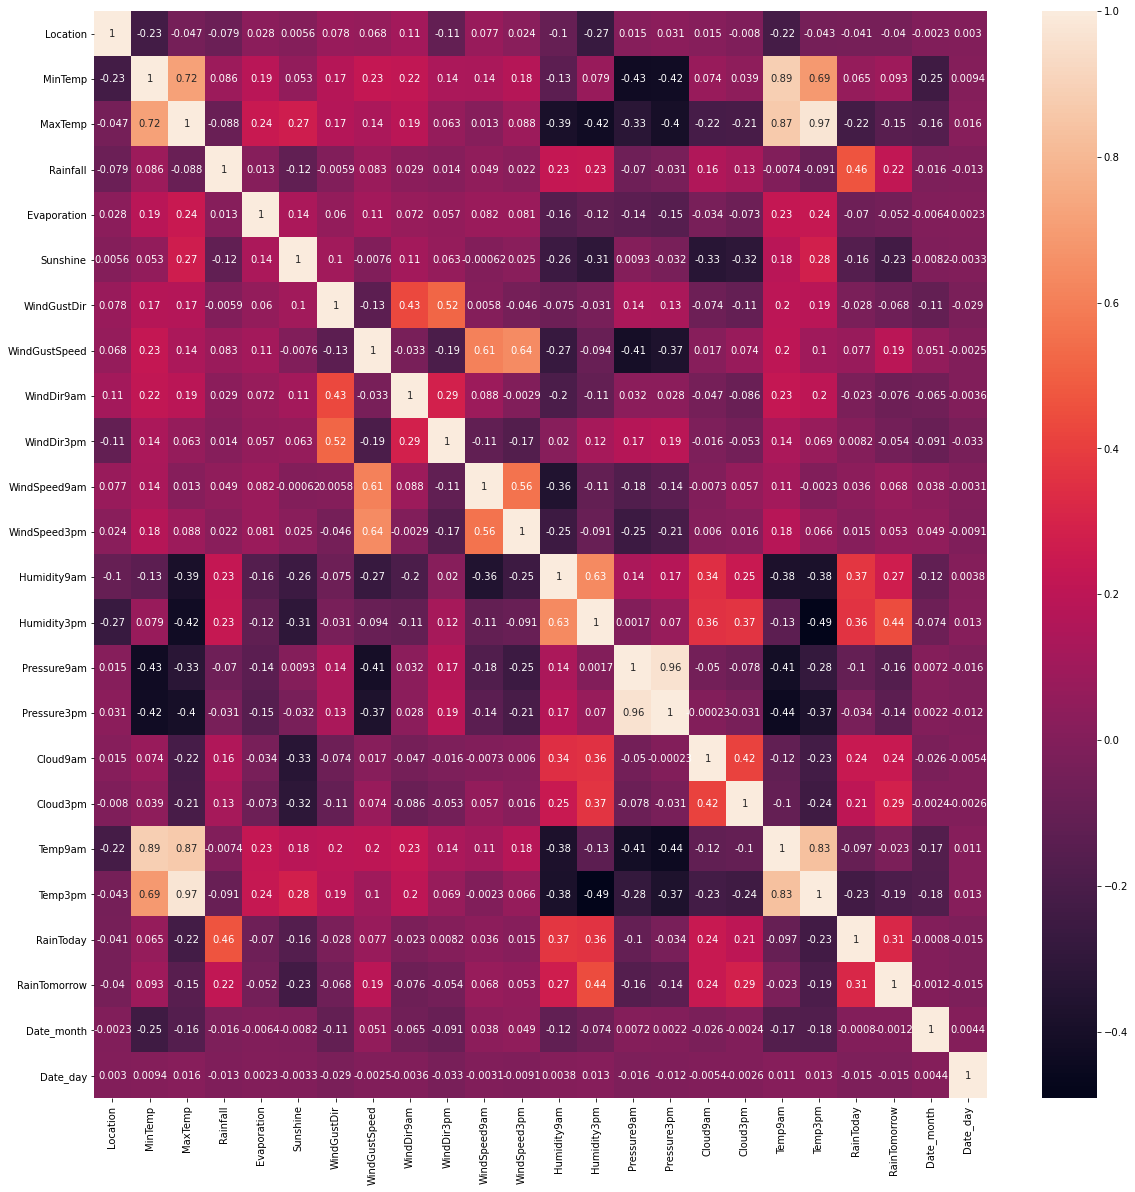

In [88]:
corrmat = df.corr()
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

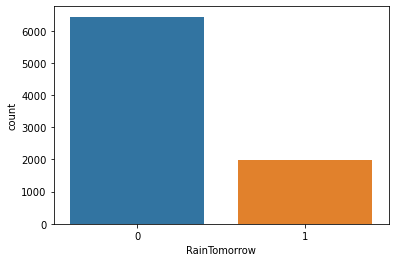

In [89]:
sns.countplot(df["RainTomorrow"])

In [90]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,30,13.4,22.9,0.6,3.0,13.8,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,8.0,16.9,21.8,0,0,12,1
1,2008-12-02,30,7.4,25.1,0.0,2.2,7.6,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,1.0,4.0,17.2,24.3,0,0,12,2
2,2008-12-03,30,12.9,25.7,0.0,4.6,7.7,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,2.0,2.0,21.0,23.2,0,0,12,3
3,2008-12-04,30,9.2,28.0,0.0,1.8,8.0,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,8.0,7.0,18.1,26.5,0,0,12,4
4,2008-12-05,30,17.5,32.3,1.0,3.8,11.9,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2017-06-21,49,2.8,23.4,0.0,6.4,1.2,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,8.0,4.0,10.1,22.4,0,0,6,21
8421,2017-06-22,49,3.6,25.3,0.0,12.6,7.1,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,1.0,1.0,10.9,24.5,0,0,6,22
8422,2017-06-23,49,5.4,26.9,0.0,4.2,13.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,6.0,5.0,12.5,26.1,0,0,6,23
8423,2017-06-24,49,7.8,27.0,0.0,4.0,13.1,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,6,24


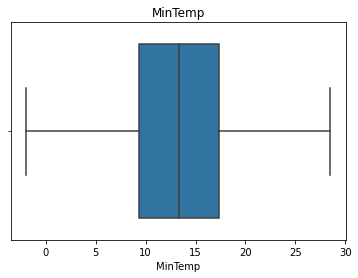

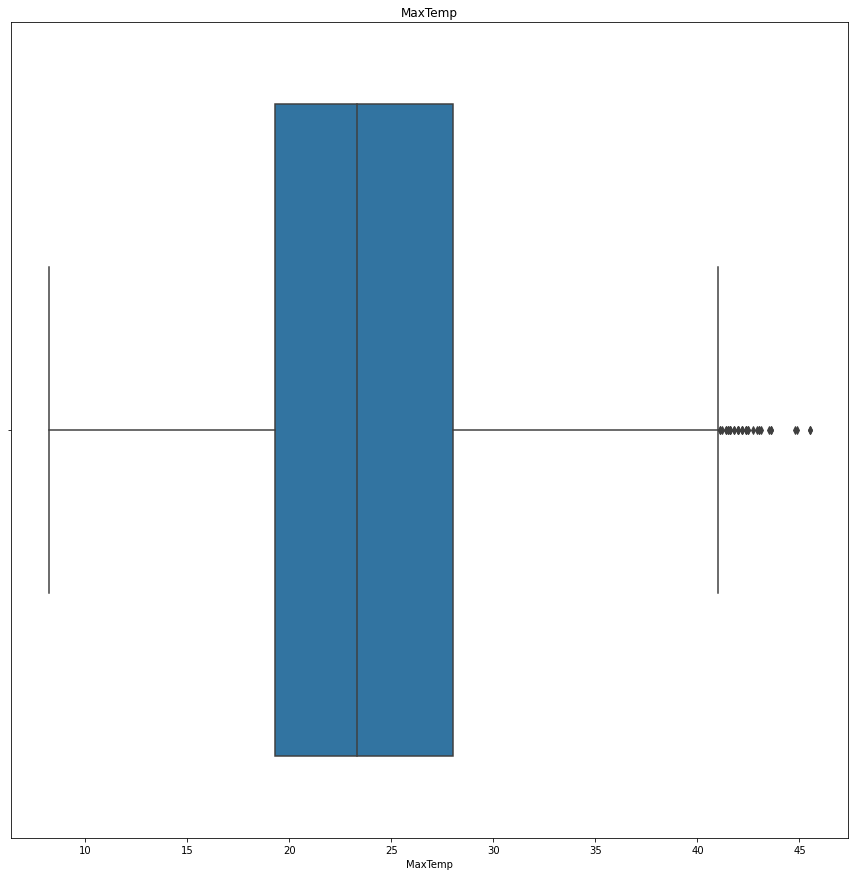

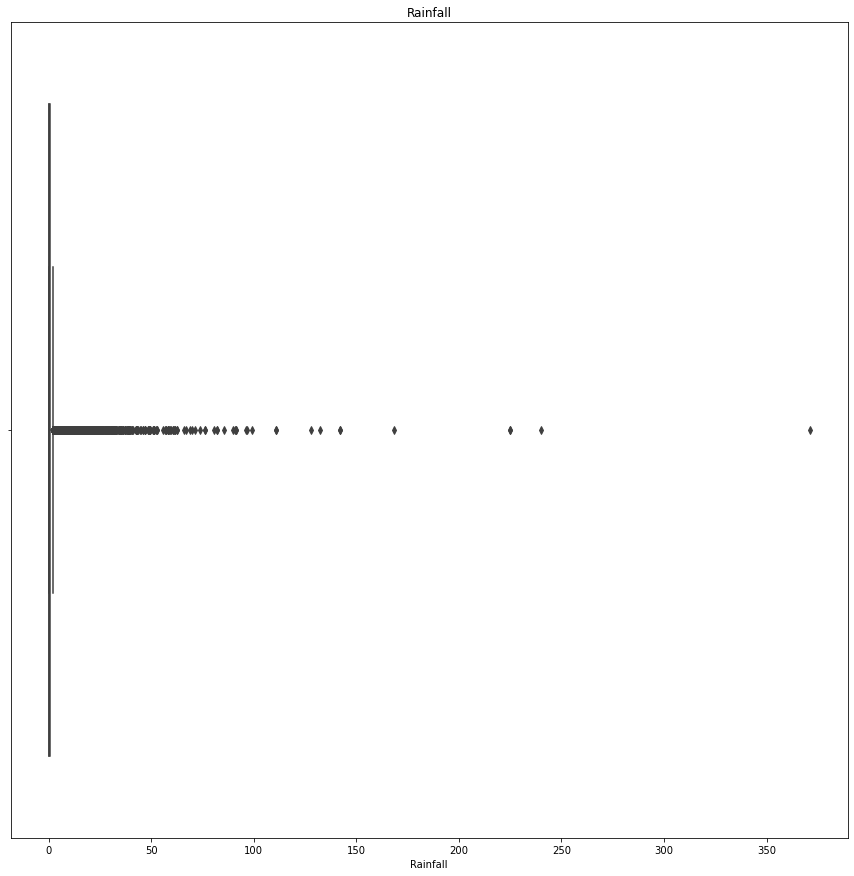

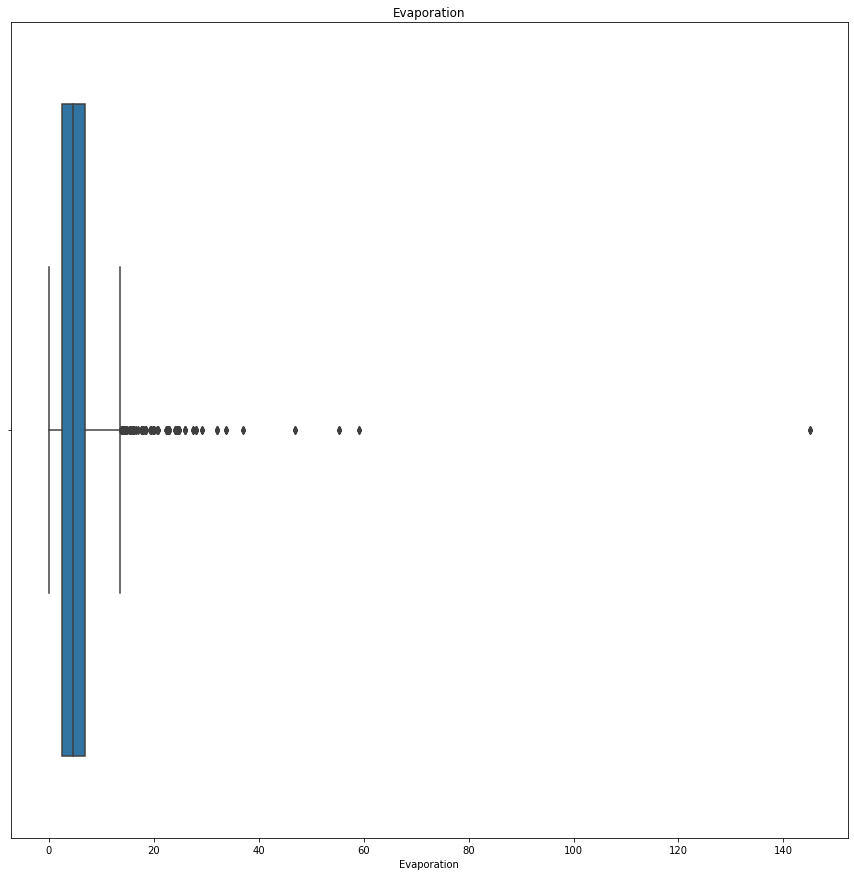

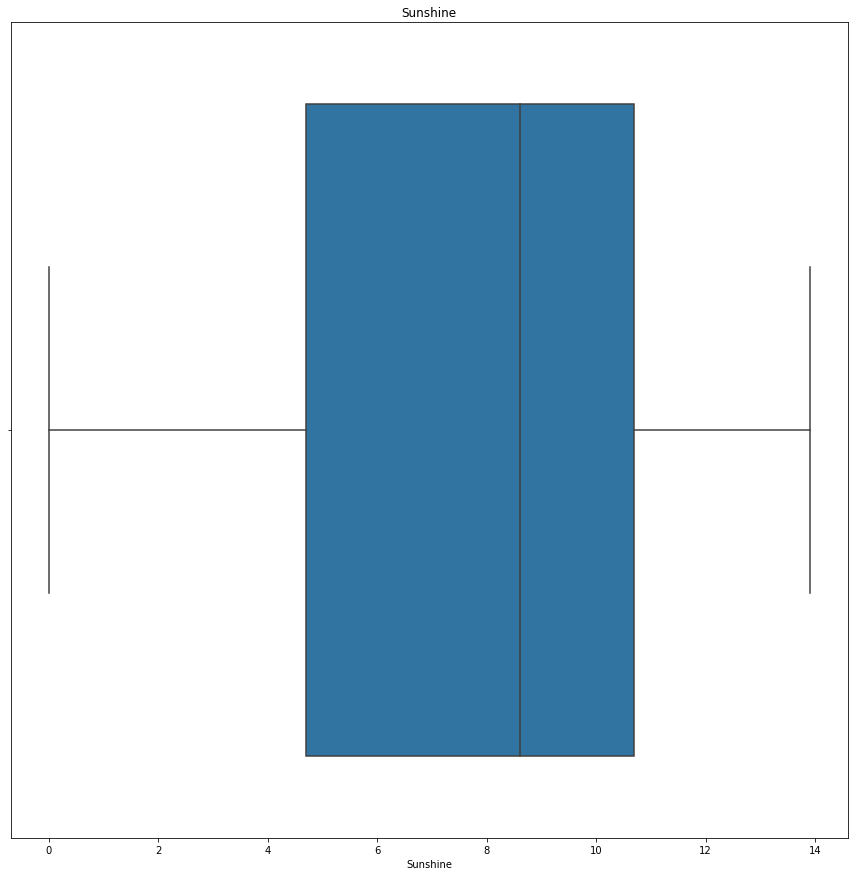

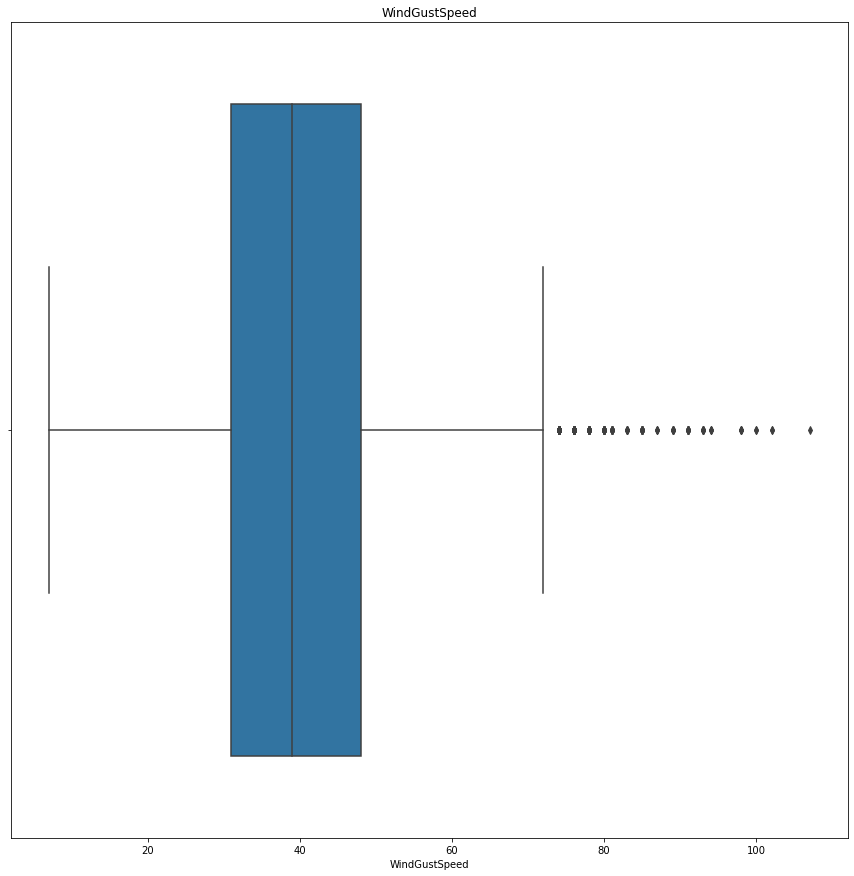

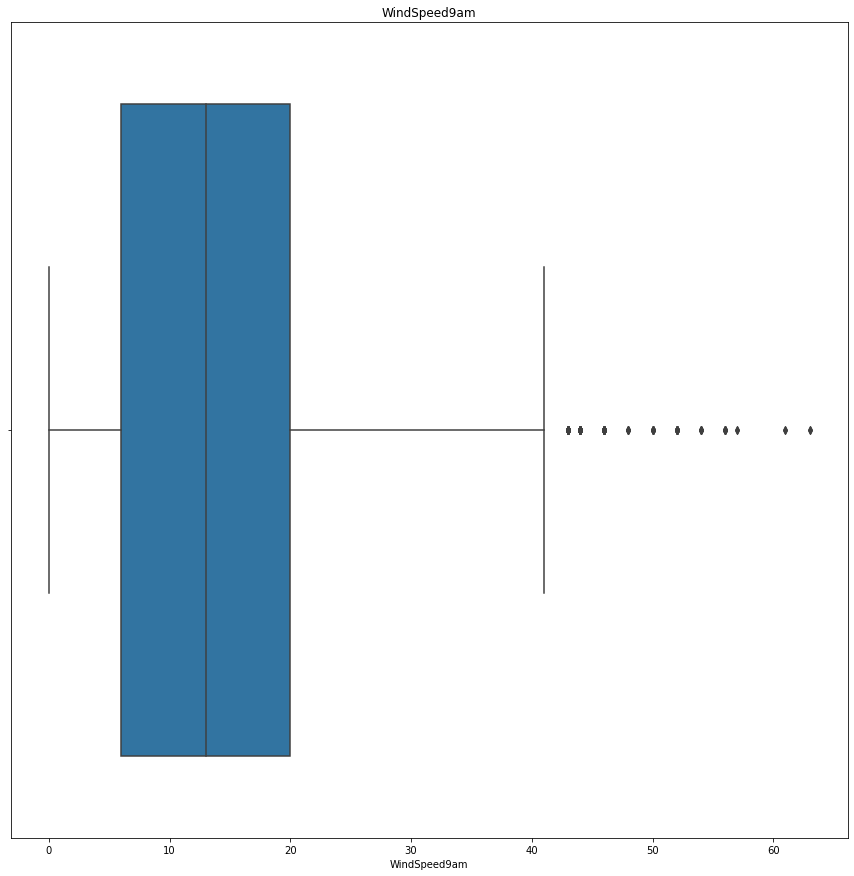

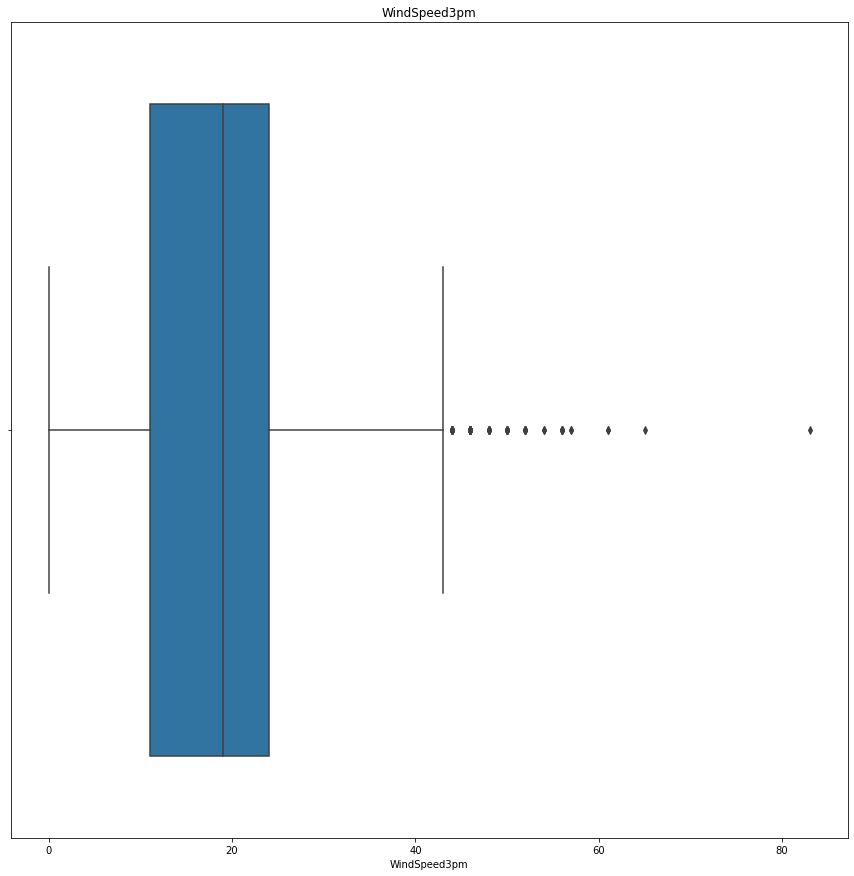

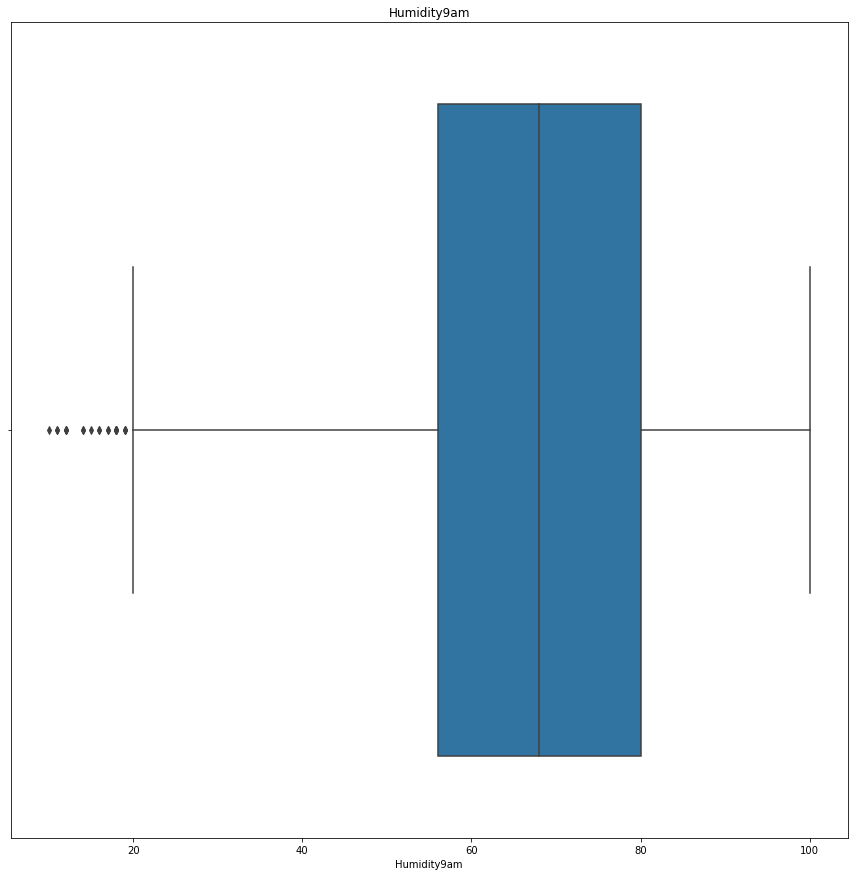

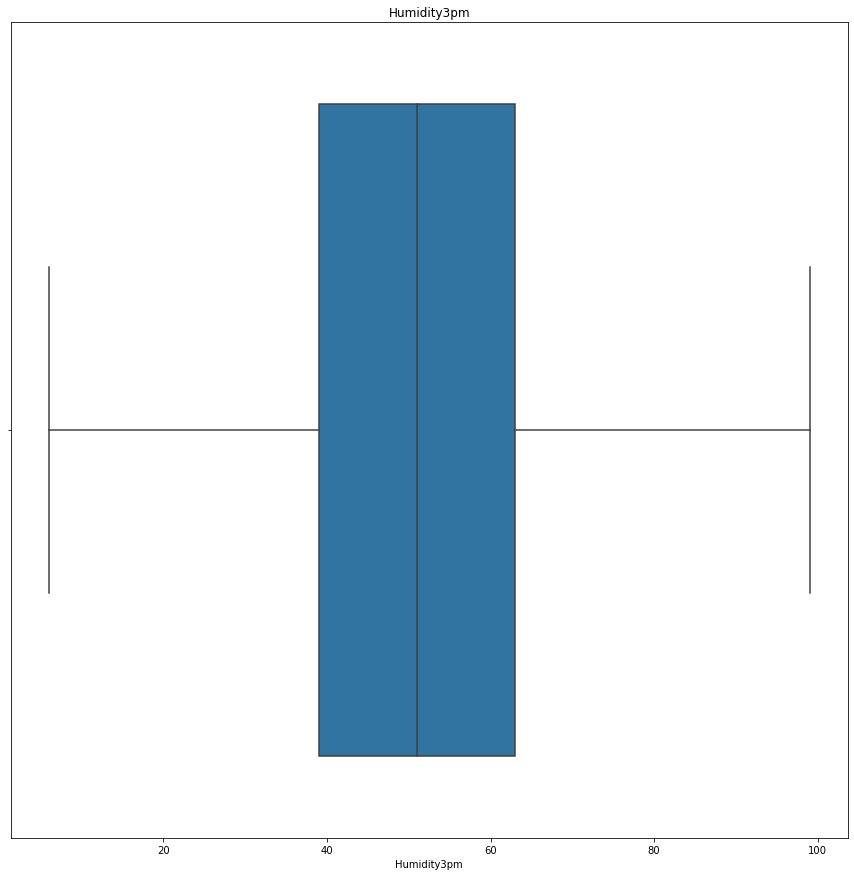

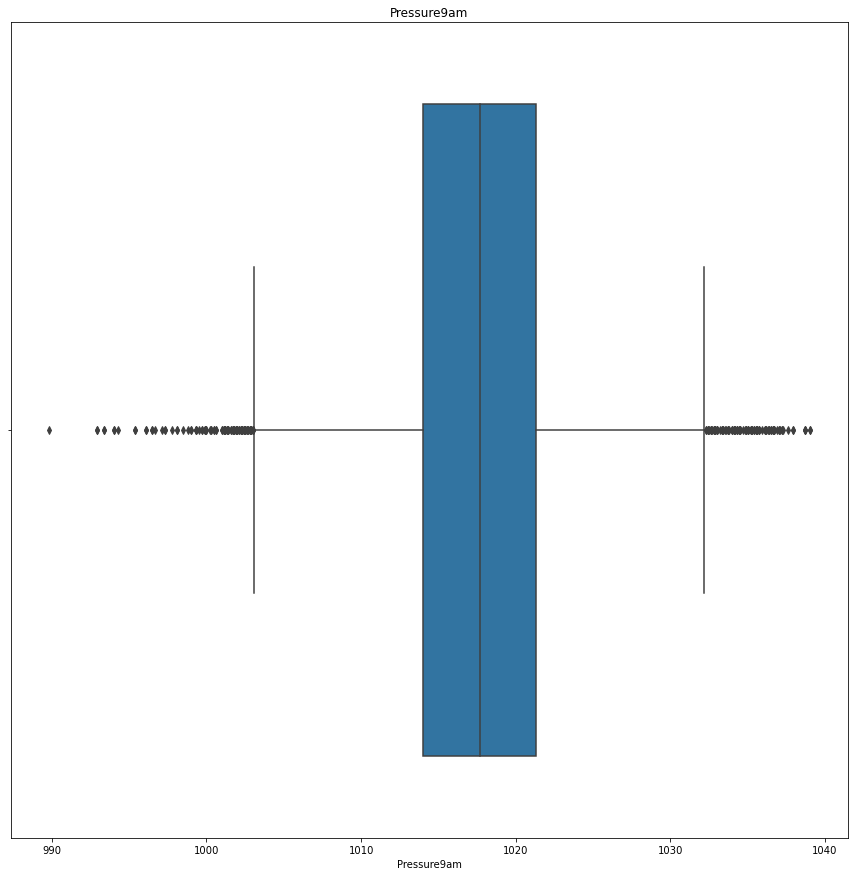

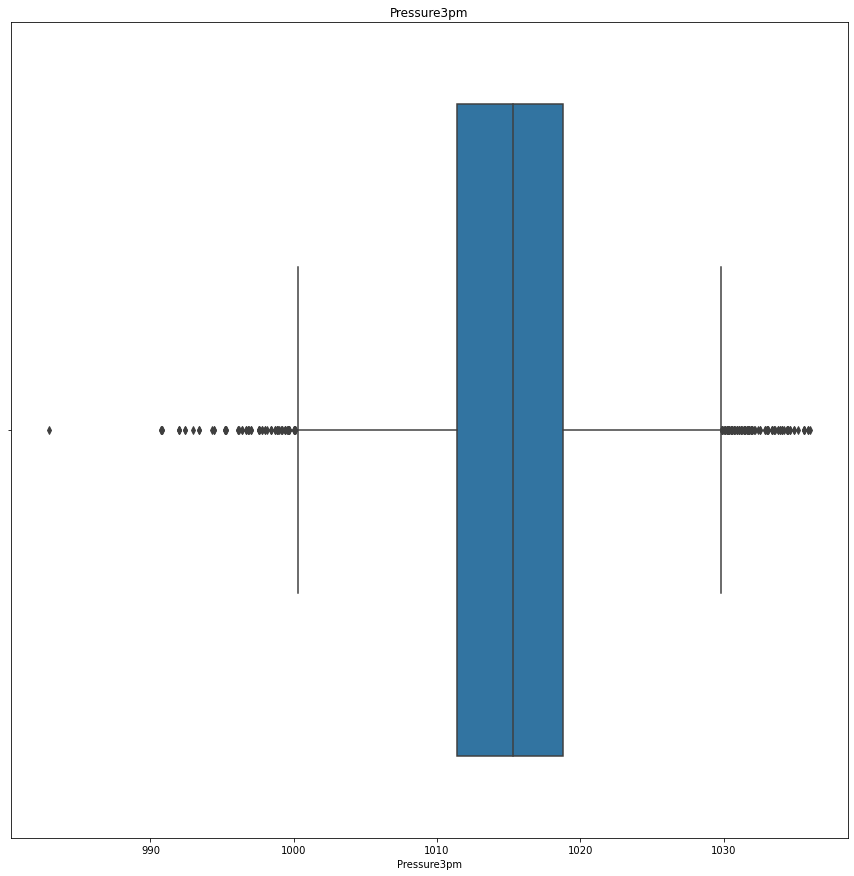

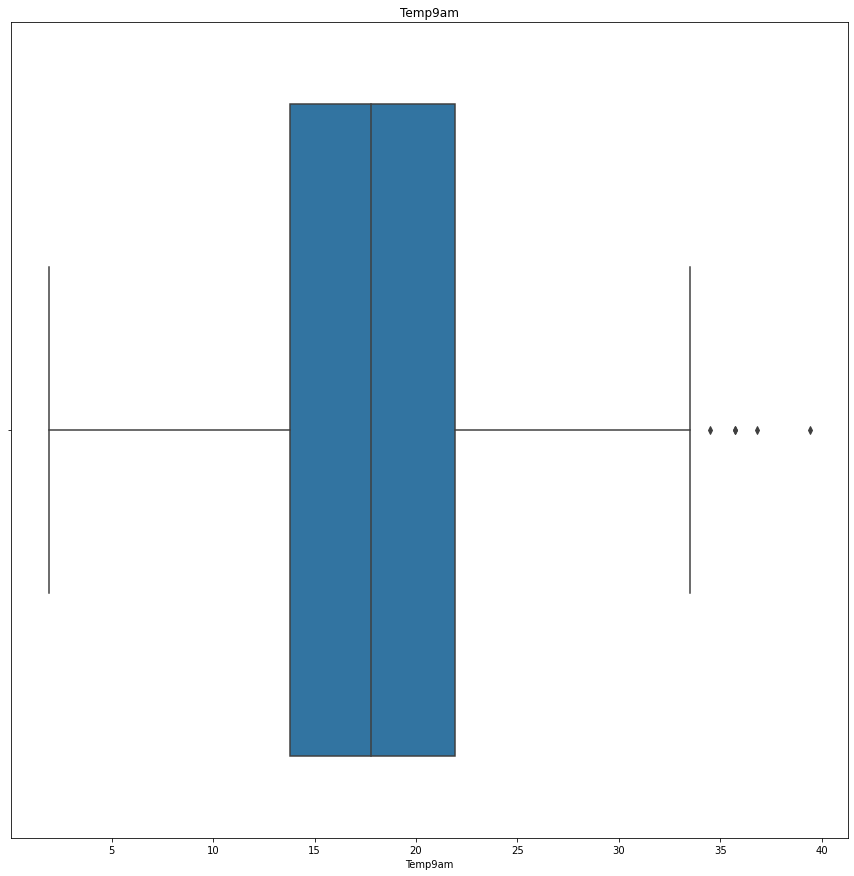

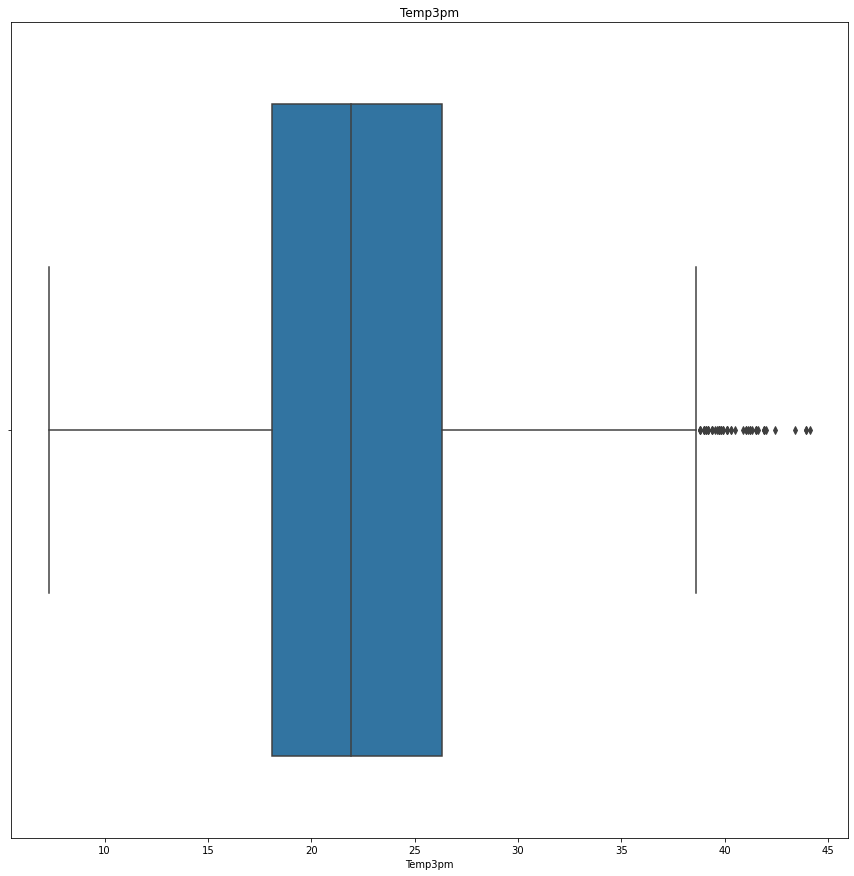

<Figure size 1080x1080 with 0 Axes>

In [91]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [92]:
for feature in continuous_feature:
    print(feature)

MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Temp9am
Temp3pm


In [93]:
IQR=df.MinTemp.quantile(0.75)-df.MinTemp.quantile(0.25)
lower_bridge=df.MinTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MinTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-2.6999999999999993 29.3


In [94]:
df.loc[df['MinTemp']>=30.45,'MinTemp']=30.45
df.loc[df['MinTemp']<=-5.95,'MinTemp']=-5.95

In [95]:
IQR=df.MaxTemp.quantile(0.75)-df.MaxTemp.quantile(0.25)
lower_bridge=df.MaxTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MaxTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

6.250000000000002 41.05


In [96]:
df.loc[df['MaxTemp']>=43.5,'MaxTemp']=43.5
df.loc[df['MaxTemp']<=2.7,'MaxTemp']=2.7

In [97]:
IQR=df.Rainfall.quantile(0.75)-df.Rainfall.quantile(0.25)
lower_bridge=df.Rainfall.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Rainfall.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-1.2000000000000002 2.0


In [98]:
df.loc[df['Rainfall']>=1.5,'Rainfall']=1.5
df.loc[df['Rainfall']<=-0.89,'Rainfall']=-0.89

In [99]:
IQR=df.Evaporation.quantile(0.75)-df.Evaporation.quantile(0.25)
lower_bridge=df.Evaporation.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Evaporation.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-4.0 13.600000000000001


In [100]:
df.loc[df['Evaporation']>=14.6,'Evaporation']=14.6
df.loc[df['Evaporation']<=-4.6,'Evaporation']=-4.6

In [101]:
IQR=df.WindGustSpeed.quantile(0.75)-df.WindGustSpeed.quantile(0.25)
lower_bridge=df.WindGustSpeed.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindGustSpeed.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

5.5 73.5


In [102]:
df.loc[df['WindGustSpeed']>=68.5,'WindGustSpeed']=68.5
df.loc[df['WindGustSpeed']<=8.5,'WindGustSpeed']=8.5

IQR=df.WindSpeed9am.quantile(0.75)-df.WindSpeed9am.quantile(0.25)
lower_bridge=df.WindSpeed9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-15.0 41.0


In [103]:
df.loc[df['WindSpeed9am']>=37,'WindSpeed9am']=37
df.loc[df['WindSpeed9am']<=-11,'WindSpeed9am']=-11

IQR=df.WindSpeed3pm.quantile(0.75)-df.WindSpeed3pm.quantile(0.25)
lower_bridge=df.WindSpeed3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-8.5 43.5


In [104]:
df.loc[df['WindSpeed3pm']>40.5,'WindSpeed3pm']=40.5
df.loc[df['WindSpeed3pm']<=-3.5,'WindSpeed3pm']=-3.5

IQR=df.Humidity9am.quantile(0.75)-df.Humidity9am.quantile(0.25)
lower_bridge=df.Humidity9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Humidity9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

20.0 116.0


In [105]:
df.loc[df['Humidity9am']>=122,'Humidity9am']=122
df.loc[df['Humidity9am']<=18,'Humidity9am']=18

IQR=df.Pressure9am.quantile(0.75)-df.Pressure9am.quantile(0.25)
lower_bridge=df.Pressure9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

1003.0500000000001 1032.25


In [106]:
df.loc[df['Pressure9am']>=1034.25,'Pressure9am']=1034.25
df.loc[df['Pressure9am']<=1001.05,'Pressure9am']=1001.05

IQR=df.Pressure3pm.quantile(0.75)-df.Pressure3pm.quantile(0.25)
lower_bridge=df.Pressure3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

1000.3 1029.8999999999999


In [107]:
df.loc[df['Pressure3pm']>=1031.85,'Pressure3pm']=1031.85
df.loc[df['Pressure3pm']<=998.65,'Pressure3pm']=998.65

IQR=df.Temp9am.quantile(0.75)-df.Temp9am.quantile(0.25)
lower_bridge=df.Temp9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)


1.650000000000004 34.05


In [108]:
df.loc[df['Temp9am']>=35.3,'Temp9am']=35.3
df.loc[df['Temp9am']<=-1.49,'Temp9am']=-1.49

IQR=df.Temp3pm.quantile(0.75)-df.Temp3pm.quantile(0.25)
lower_bridge=df.Temp3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)



5.8000000000000025 38.6


In [109]:
df.loc[df['Temp3pm']>=40.45,'Temp3pm']=40.45
df.loc[df['Temp3pm']<=2.45,'Temp3pm']=2.45

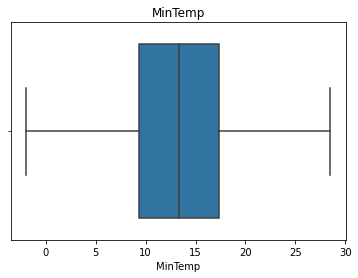

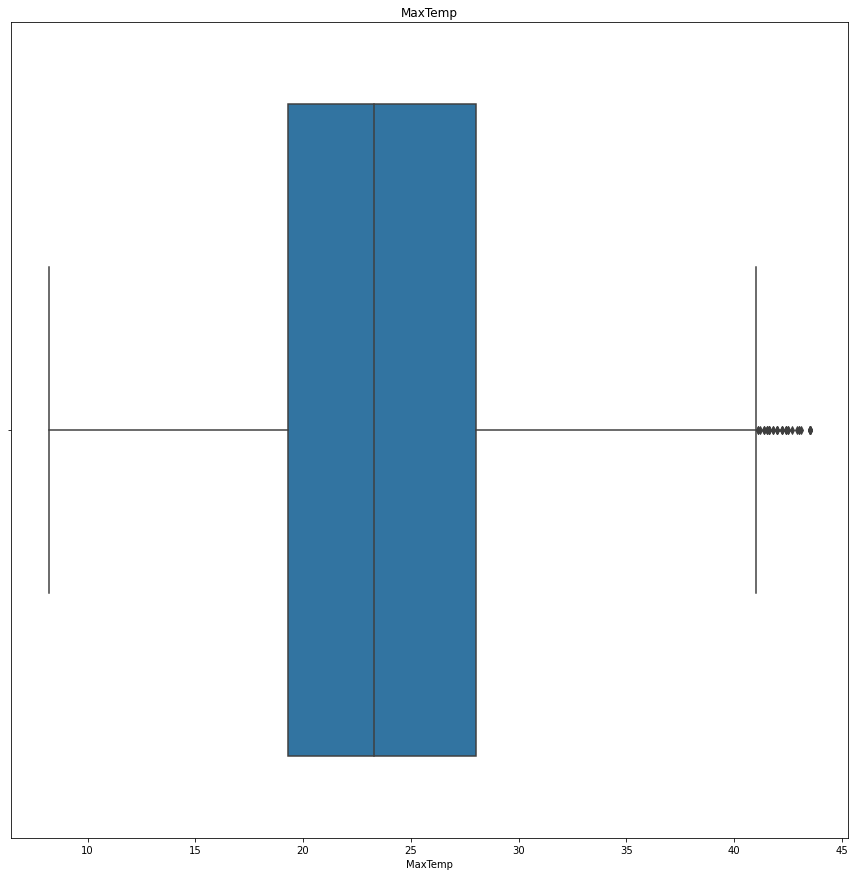

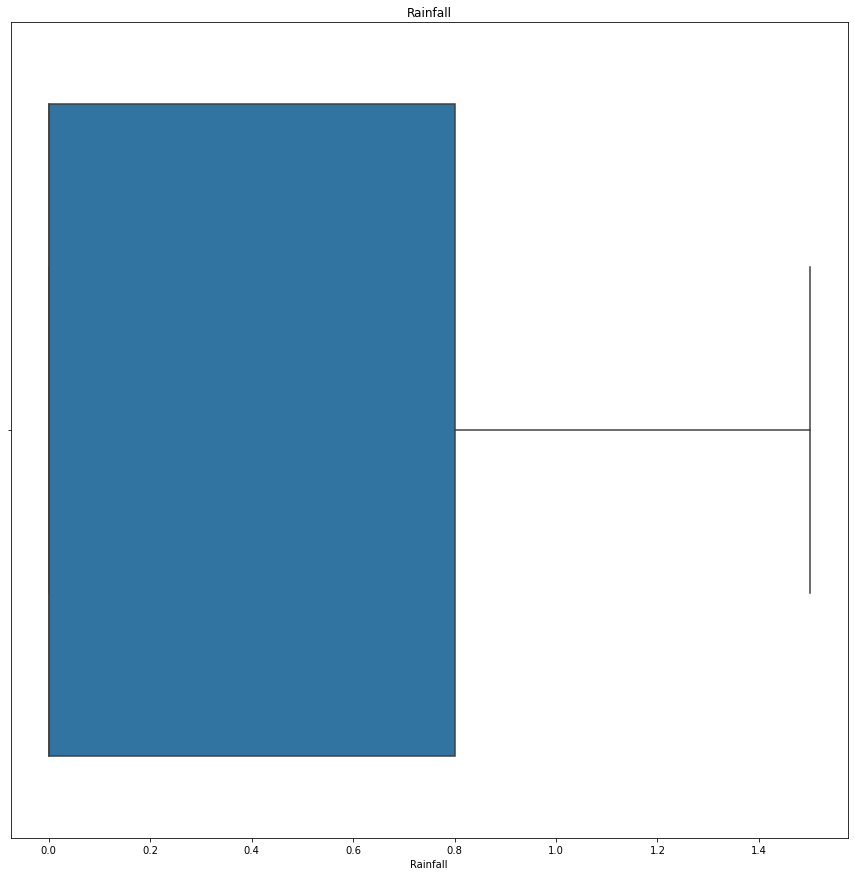

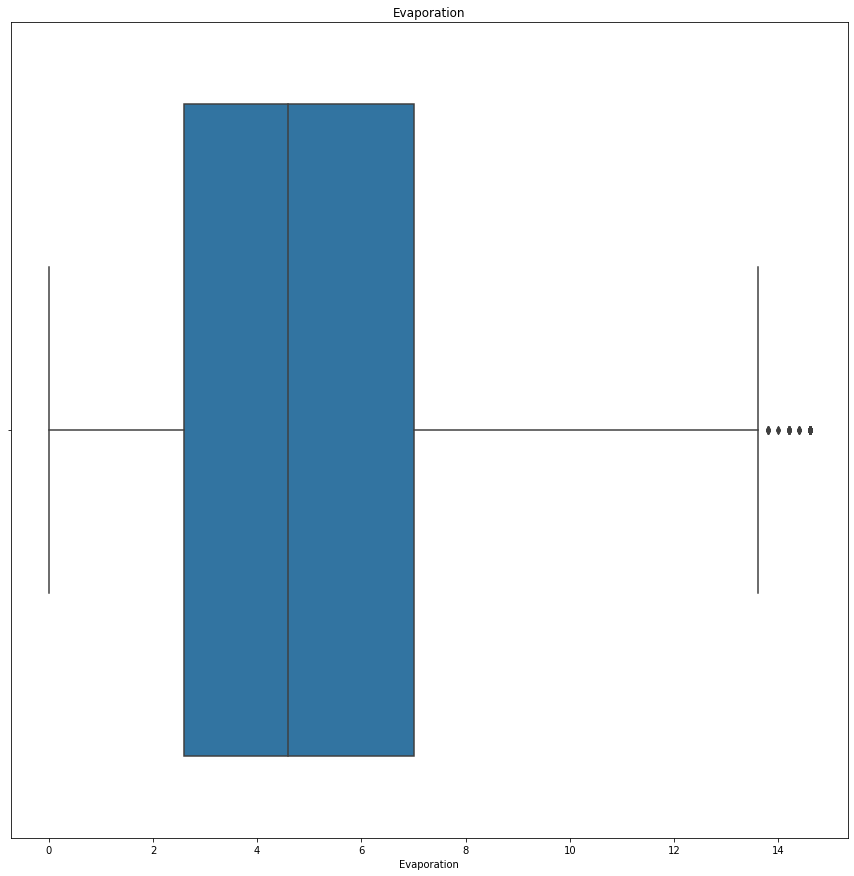

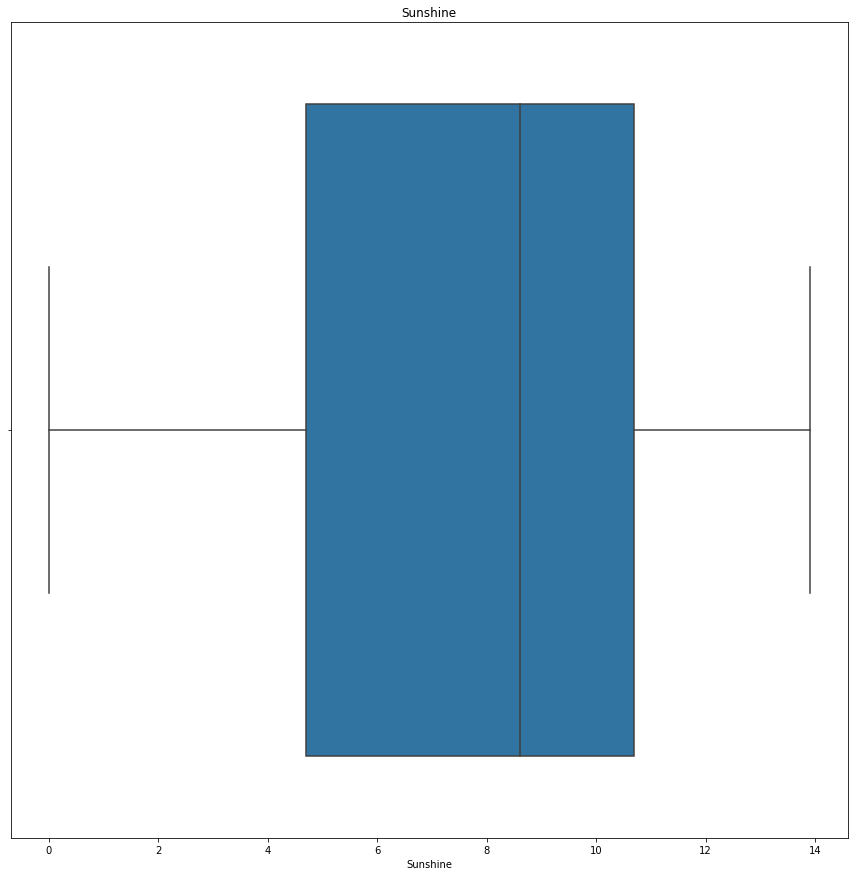

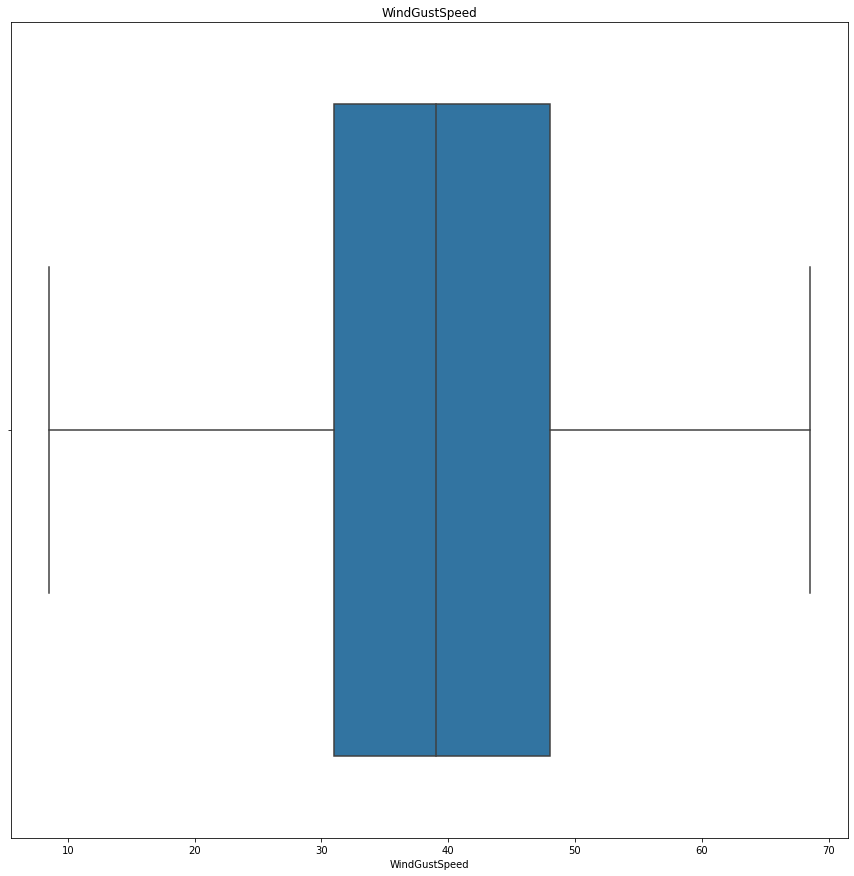

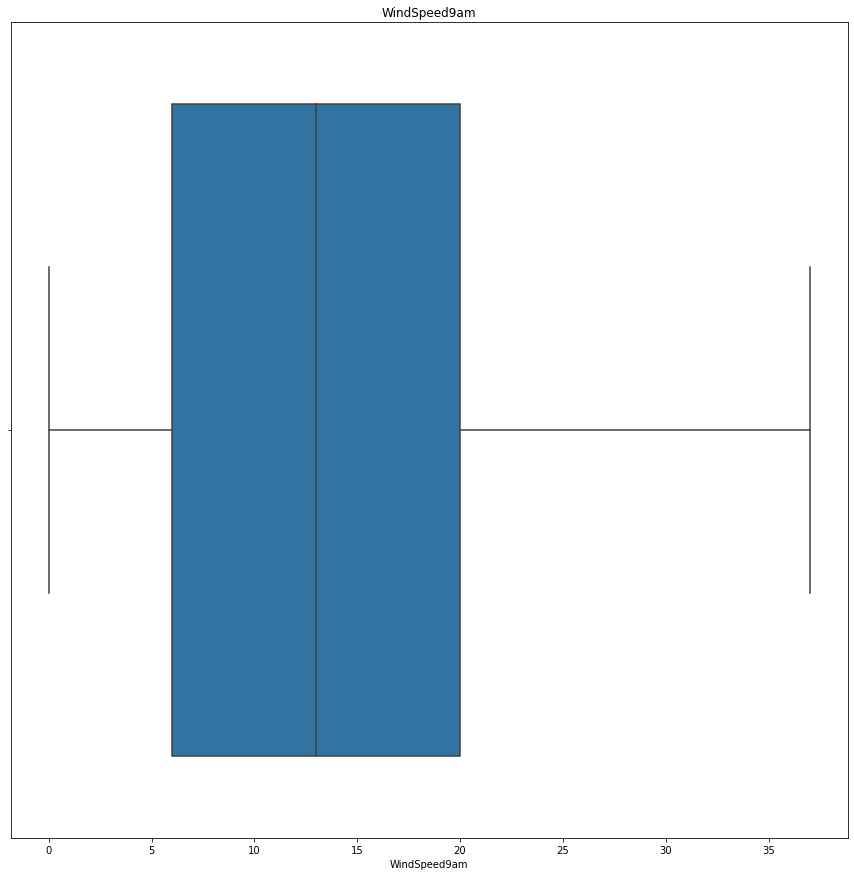

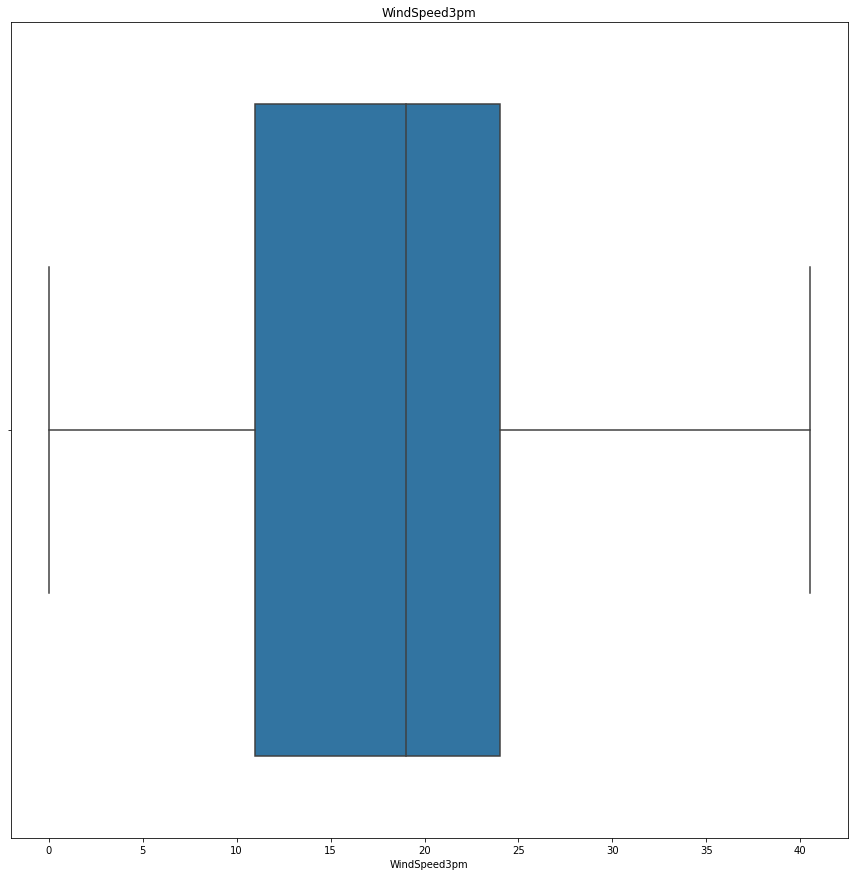

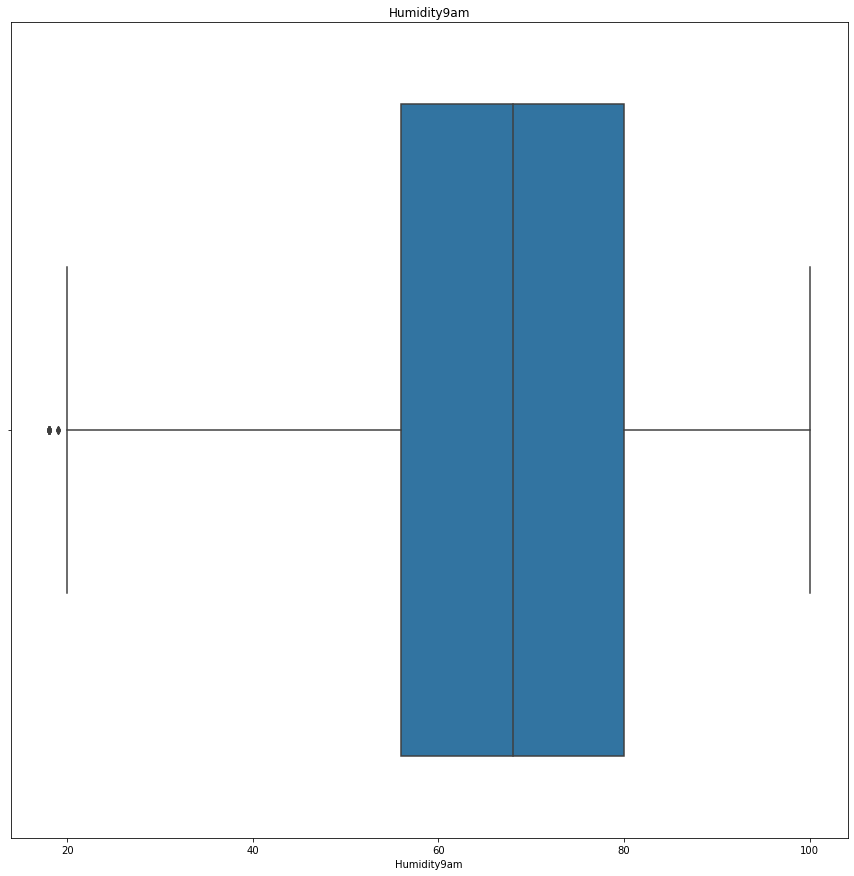

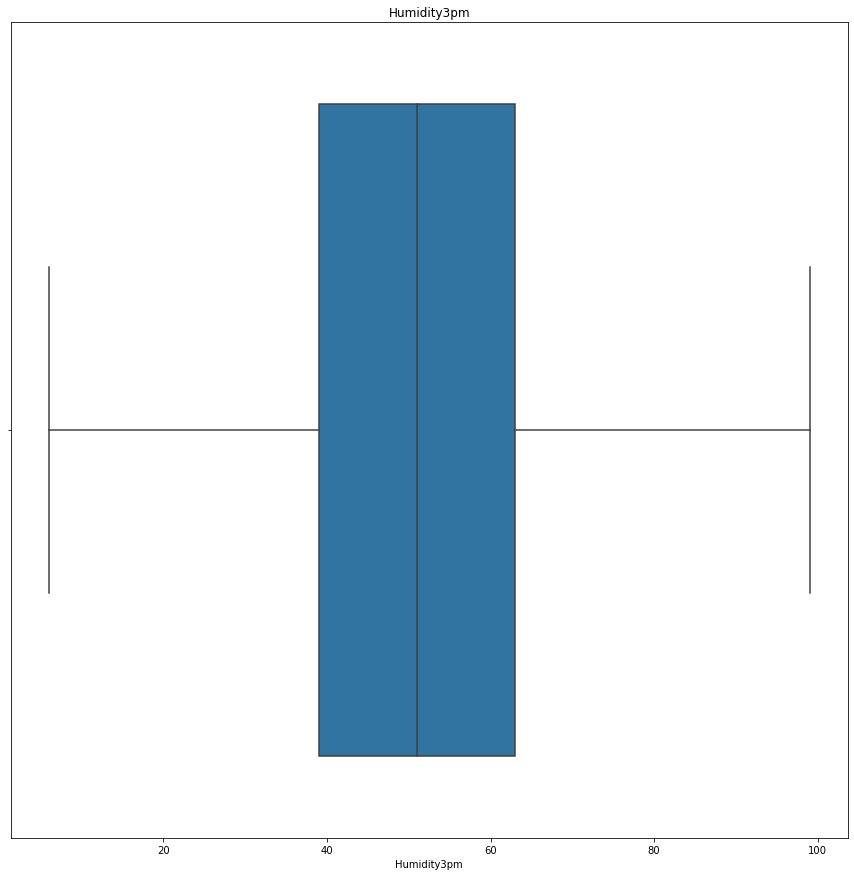

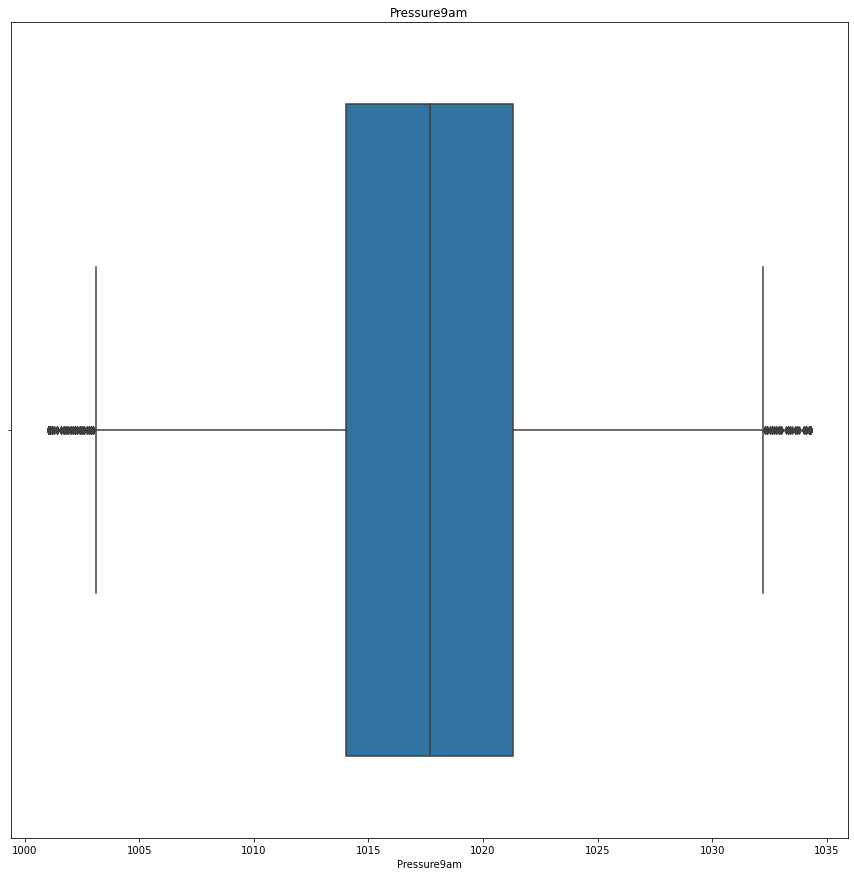

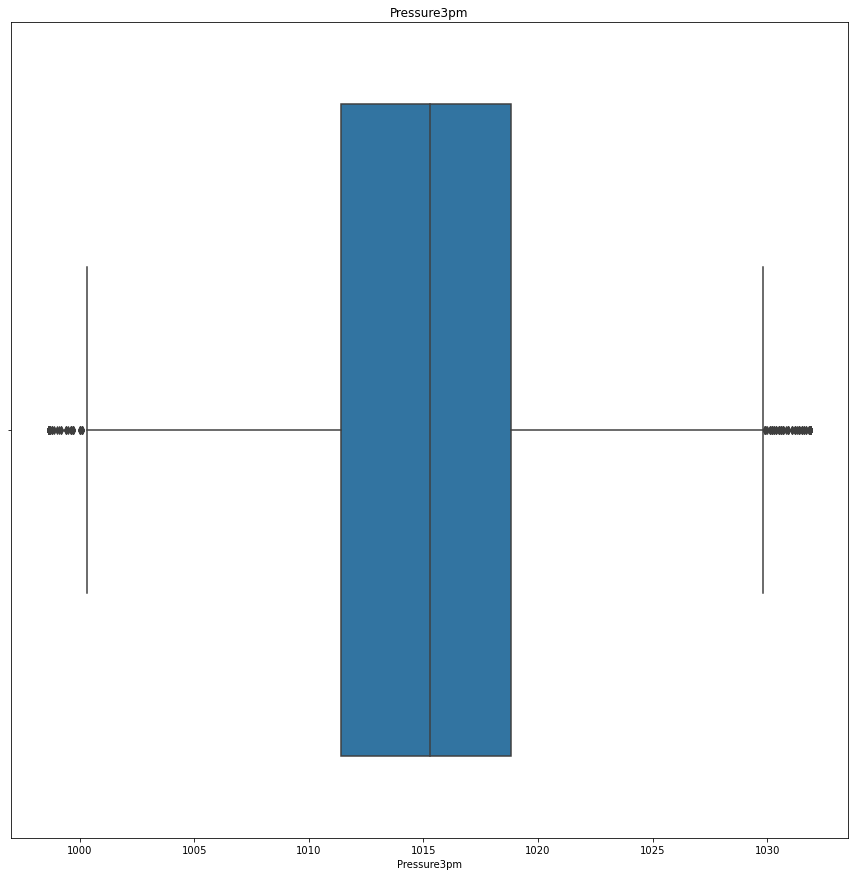

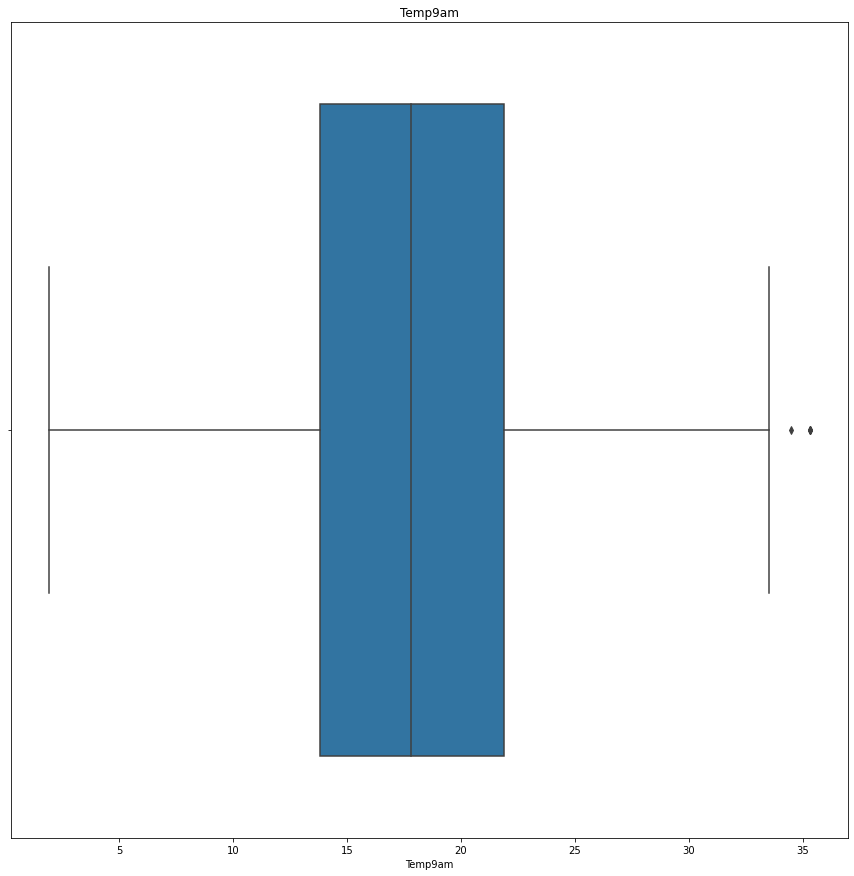

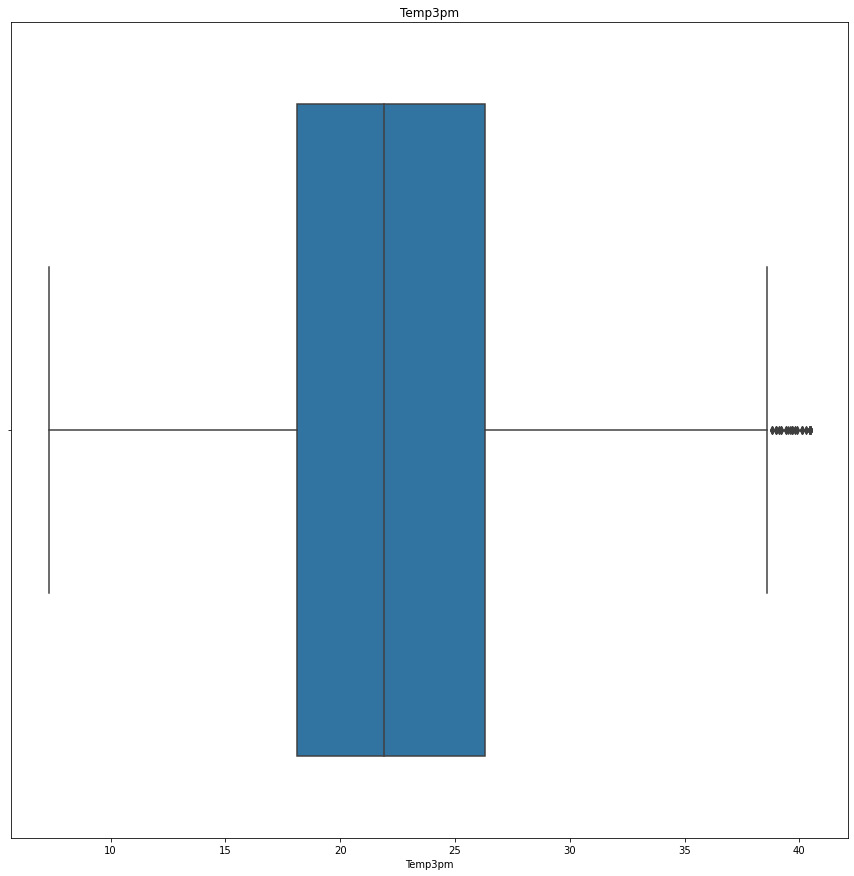

<Figure size 1080x1080 with 0 Axes>

In [110]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))


In [111]:
df.to_csv(r"https://raw.githubusercontent.com/dsrscientist/dataset3/main/weatherAUS.csv", index=False)

In [112]:
X = df.drop(["RainTomorrow", "Date"], axis=1)
Y = df["RainTomorrow"]

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size =0.2, stratify = Y, random_state = 0)

In [114]:
y_train

5490    0
5525    0
95      0
7404    0
6844    0
       ..
8222    0
8169    0
2784    0
7922    0
4262    0
Name: RainTomorrow, Length: 6740, dtype: uint8

In [115]:
sm=SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_res)))

The number of classes before fit Counter({0: 5147, 1: 1593})
The number of classes after fit Counter({0: 5147, 1: 5147})


In [116]:
cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")
cat.fit(X_train_res, y_train_res)


Learning rate set to 0.014766
0:	total: 145ms	remaining: 4m 48s
1:	total: 151ms	remaining: 2m 31s
2:	total: 158ms	remaining: 1m 44s
3:	total: 164ms	remaining: 1m 21s
4:	total: 170ms	remaining: 1m 7s
5:	total: 176ms	remaining: 58.6s
6:	total: 183ms	remaining: 52.1s
7:	total: 189ms	remaining: 47.1s
8:	total: 198ms	remaining: 43.8s
9:	total: 204ms	remaining: 40.5s
10:	total: 209ms	remaining: 37.8s
11:	total: 215ms	remaining: 35.6s
12:	total: 220ms	remaining: 33.6s
13:	total: 227ms	remaining: 32.2s
14:	total: 234ms	remaining: 31s
15:	total: 239ms	remaining: 29.7s
16:	total: 244ms	remaining: 28.5s
17:	total: 249ms	remaining: 27.5s
18:	total: 254ms	remaining: 26.5s
19:	total: 259ms	remaining: 25.7s
20:	total: 264ms	remaining: 24.9s
21:	total: 269ms	remaining: 24.2s
22:	total: 275ms	remaining: 23.6s
23:	total: 281ms	remaining: 23.1s
24:	total: 286ms	remaining: 22.6s
25:	total: 291ms	remaining: 22.1s
26:	total: 296ms	remaining: 21.6s
27:	total: 301ms	remaining: 21.2s
28:	total: 306ms	remaining

In [117]:
y_pred = cat.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1216   71]
 [ 153  245]]
0.8670623145400593
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1287
           1       0.78      0.62      0.69       398

    accuracy                           0.87      1685
   macro avg       0.83      0.78      0.80      1685
weighted avg       0.86      0.87      0.86      1685



0.7802054171400905

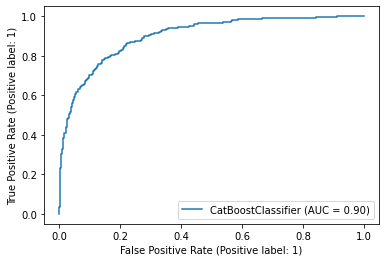

In [118]:
metrics.plot_roc_curve(cat, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred, average=None) 

In [119]:
rf=RandomForestClassifier()
rf.fit(X_train_res,y_train_res)

RandomForestClassifier()

In [120]:
y_pred1 = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred1))
print(accuracy_score(y_test,y_pred1))
print(classification_report(y_test,y_pred1))

[[1218   69]
 [ 134  264]]
0.8795252225519288
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1287
           1       0.79      0.66      0.72       398

    accuracy                           0.88      1685
   macro avg       0.85      0.80      0.82      1685
weighted avg       0.88      0.88      0.88      1685



0.8048517646507597

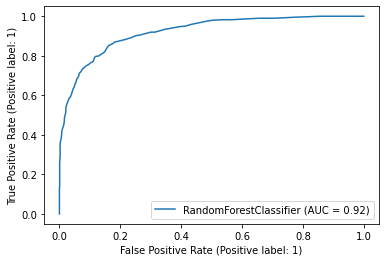

In [121]:
metrics.plot_roc_curve(rf, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred1, average=None) 

In [122]:
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)

LogisticRegression()

In [123]:
y_pred2 = logreg.predict(X_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

[[993 294]
 [105 293]]
0.7632047477744807
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1287
           1       0.50      0.74      0.59       398

    accuracy                           0.76      1685
   macro avg       0.70      0.75      0.71      1685
weighted avg       0.81      0.76      0.78      1685



0.7538713380421923

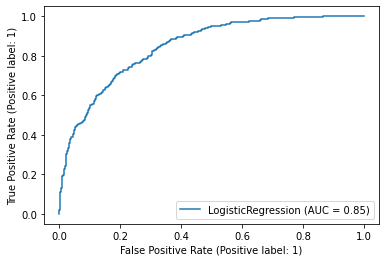

In [124]:
metrics.plot_roc_curve(logreg, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred2, average=None)

In [125]:
gnb = GaussianNB()
gnb.fit(X_train_res, y_train_res)

GaussianNB()

In [126]:
y_pred3 = gnb.predict(X_test)
print(confusion_matrix(y_test,y_pred3))
print(accuracy_score(y_test,y_pred3))
print(classification_report(y_test,y_pred3))

[[953 334]
 [100 298]]
0.742433234421365
              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1287
           1       0.47      0.75      0.58       398

    accuracy                           0.74      1685
   macro avg       0.69      0.74      0.70      1685
weighted avg       0.80      0.74      0.76      1685



0.7446127295373527

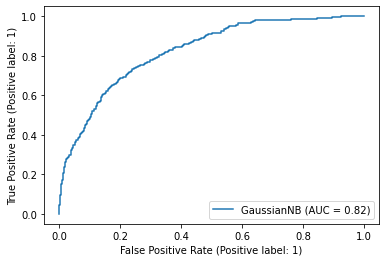

In [127]:
metrics.plot_roc_curve(gnb, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred3, average=None) 

In [128]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_res, y_train_res)


KNeighborsClassifier(n_neighbors=3)

[[1006  281]
 [  98  300]]
0.7750741839762612
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1287
           1       0.52      0.75      0.61       398

    accuracy                           0.78      1685
   macro avg       0.71      0.77      0.73      1685
weighted avg       0.82      0.78      0.79      1685



0.7677158129419437

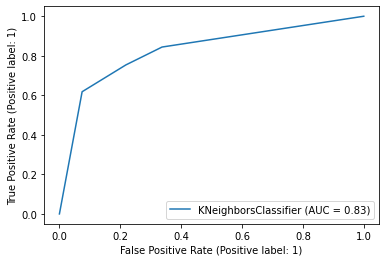

In [129]:
y_pred4 = knn.predict(X_test)
print(confusion_matrix(y_test,y_pred4))
print(accuracy_score(y_test,y_pred4))
print(classification_report(y_test,y_pred4))

metrics.plot_roc_curve(knn, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred4, average=None) 


In [131]:
xgb = XGBClassifier()
xgb.fit(X_train_res, y_train_res)
 


[19:38:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [132]:
y_pred6 = xgb.predict(X_test)
print(confusion_matrix(y_test,y_pred6))
print(accuracy_score(y_test,y_pred6))
print(classification_report(y_test,y_pred6))

[[1224   63]
 [ 144  254]]
0.8771513353115727
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1287
           1       0.80      0.64      0.71       398

    accuracy                           0.88      1685
   macro avg       0.85      0.79      0.82      1685
weighted avg       0.87      0.88      0.87      1685



0.7946199529114101

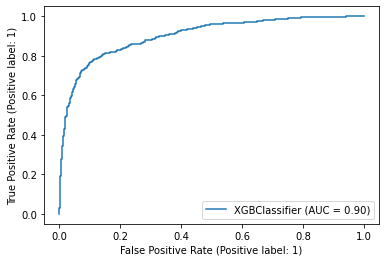

In [133]:
metrics.plot_roc_curve(xgb, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred6, average=None) 

In [134]:
svc = SVC()
svc.fit(X_train_res, y_train_res)

y_pred5 = svc.predict(X_test)
print(confusion_matrix(y_test,y_pred5))
print(accuracy_score(y_test,y_pred5))
print(classification_report(y_test,y_pred5))

[[1006  281]
 [ 107  291]]
0.7697329376854599
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1287
           1       0.51      0.73      0.60       398

    accuracy                           0.77      1685
   macro avg       0.71      0.76      0.72      1685
weighted avg       0.81      0.77      0.78      1685



0.756409280278627

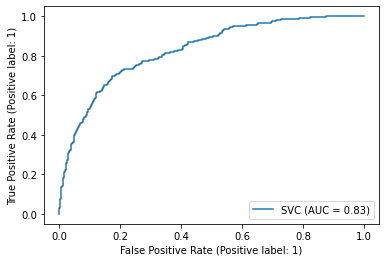

In [135]:
metrics.plot_roc_curve(svc, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred5, average=None)

In [136]:
joblib.dump(svc, "svc.pkl")
joblib.dump(xgb, "xgb.pkl")

['xgb.pkl']